In [1]:
from datetime import date
from glob import glob
import json
import os
from pathlib import Path
import pickle
import sys
import time

from matplotlib.colorbar import Colorbar
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from scipy import interpolate, signal, stats, fftpack, ndimage
import seaborn as sns
import bombcell as bc
import statsmodels.formula.api as smf

✅ ipywidgets available - interactive GUI ready


In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp

In [4]:
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_evoked_traces, get_events_wdict, find_nearest_ind

In [5]:
%matplotlib ipympl

In [6]:
plotdir = r"C:\Users\lesliec\OneDrive - Allen Institute\analysis\GAT1-KO_analyses\spont_FR"

Color pallete:
<br>SLC6A1-/-, spontaneous: "xkcd:dark teal",
<br>SLC6A1-/-, SWD: "xkcd:pumpkin",
<br>C57-WT: "xkcd:grey"

### Functions

In [7]:
## Using bombcell classification for striatum (https://github.com/Julie-Fabre/bombcell/blob/main/py_bombcell/bombcell/classification.py)
def get_put_cell_types(unit_info):
    ## bombcell classification parameters ##
    templateDuration_CP_threshold = 400  # microseconds
    postSpikeSup_CP_threshold = 40       # milliseconds  
    propISI_CP_threshold = 0.1
    templateDuration_Ctx_threshold = 400  # microseconds
    templateDuration_TH_threshold = 325  # microseconds

    put_cell_type = []
    for unitind, unitrow in unit_info.iterrows():
        if unitrow.parent_region == 'STR':
            if (np.isnan(unitrow.spike_duration) or # If any required property is missing, assign Unknown
                np.isnan(unitrow.bc_ps_supp_ms) or 
                np.isnan(unitrow.bc_proplongisi)):
                put_cell_type.append('unknown')
                continue
            if (unitrow.spike_duration * 1E3 > templateDuration_CP_threshold and # MSN: wide waveform AND short post-spike suppression
                unitrow.bc_ps_supp_ms < postSpikeSup_CP_threshold):
                put_cell_type.append('MSN')
            elif (unitrow.spike_duration * 1E3 <= templateDuration_CP_threshold and # FSI: narrow waveform AND low proportion of long ISIs
                  unitrow.bc_proplongisi <= propISI_CP_threshold):
                put_cell_type.append('FSI')
            elif (unitrow.spike_duration * 1E3 > templateDuration_CP_threshold and # TAN: wide waveform AND long post-spike suppression
                  unitrow.bc_ps_supp_ms >= postSpikeSup_CP_threshold):
                put_cell_type.append('TAN')
            elif (unitrow.spike_duration * 1E3 <= templateDuration_CP_threshold and # UIN: narrow waveform AND high proportion of long ISIs
                  unitrow.bc_proplongisi > propISI_CP_threshold):
                put_cell_type.append('UIN')
            else: # Should not reach here with valid data
                put_cell_type.append('unknown')
        elif unitrow.parent_region in ['MO', 'SS', 'VIS', 'PL', 'ACA', 'ILA', 'ORB', 'RSP', 'HIP']:
            if unitrow.spike_duration * 1E3 > templateDuration_Ctx_threshold:
                put_cell_type.append('RS')
            else:
                put_cell_type.append('FS')
        elif unitrow.parent_region == 'TH':
            if unitrow.spike_duration * 1E3 < templateDuration_TH_threshold:
                put_cell_type.append('pRT')
            else:
                put_cell_type.append('TC')
        else:
            put_cell_type.append('unknown')
    unit_info['cell_type'] = put_cell_type
    return unit_info

# Load multi session .csv

In [8]:
subject_csv = Path(r"C:\Users\lesliec\OneDrive - Allen Institute\analysis\GAT1-KO_analyses\GAT1_control_NPephys_subjects.csv")
all_subexp = pd.read_csv(subject_csv, converters={'mouse': str})
all_subexp.head()

genotype   mouse                             experiment        drug  \
0  SLC6A1-/-  645606  EEGNPXspont_estim_2022-12-20_12-26-39        none   
1  SLC6A1-/-  644565  EEGNPXspont_estim_2022-12-22_10-36-08        none   
2  SLC6A1-/-  672785  EEGNPXspont_estim_2023-07-05_12-39-59        none   
3  SLC6A1-/-  672789  EEGNPXspont_estim_2023-07-13_13-28-01        none   
4     C57-WT  654181          estim_vis_2022-11-22_09-42-58  isoflurane   

   inj_time      sweep_states    bad_chs  CCFres  NPX_analysis  EEG_analysis  \
0         0             awake       none      25          True          True   
1         0             awake       none      25          True          True   
2         0             awake        all      25          True         False   
3         0             awake       none      25          True          True   
4         0  awake,isoflurane  7,8,11,13      25          True          True   

   skull_screws                                NPX_ref  \
0           2.0    Neuropixels tip reference electrode   
1           2.0    Neuropixels tip reference electrode   
2           2.0    Neuropixels tip reference electrode   
3           2.0  stainless steel skull screw, right CB   
4           NaN                                    NaN   

                                EEG_ref            shared_ref_gnd  \
0                                   NaN                       NaN   
1                                   NaN                       NaN   
2  stainless steel skull screw, left CB  separate ref, shared gnd   
3  stainless steel skull screw, left CB  separate ref, shared gnd   
4                                   NaN                       NaN   

                                            data_loc  \
0  E:\GAT1_EEG_pilot\mouse645606\EEGNPXspont_esti...   
1  E:\GAT1_EEG_pilot\mouse644565\EEGNPXspont_esti...   
2  E:\GAT1_EEG_pilot\mouse672785\EEGNPXspont_esti...   
3  E:\GAT1_EEG_pilot\mouse672789\EEGNPXspont_esti...   
4  F:\psi_exp\mouse654181\estim_vis_2022-11-22_09...   

                                               notes  
0                        100um offset stim electrode  
1  100um offset stim electrode, probeB LFP estim ...  
2  EEG has low amplitude signals and all chs look...  
3                                                NaN  
4  good control mouse with RT units; not Temp or ...

# Loop through all subjects to plot spontaneous firing rate for all units

In [9]:
deltat = 1. # window size, s

all_unit_info_list = []
for expind, exprow in all_subexp.iterrows():
    print('{} - {}'.format(exprow.mouse, exprow.experiment))
    if not exprow.NPX_analysis:
        print(' This experiment does NOT have good NPX data, skip it.\n\n')
        continue
    ## Load the experiment ##
    exp = EEGexp(exprow.data_loc, preprocess=False, make_stim_csv=False)
    exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find(str(exp.date.year))-1]

    ########## Load necessary data ##########
    ## Load the stim log ##
    if exp.stimulus_log_file:
        stim_log = pd.read_csv(exp.stimulus_log_file).astype({'parameter': str})
    else:
        print(' No stim log found.\n\n')
        continue
    ## Get the EEG clock timestamps ##
    eegts = np.load(exp.ephys_params['EEG']['timestamps'])
    ## Load the iso times ##
    iso_level, isots = exp.load_analog_iso()

    ## Load unit info ##
    evoked_folder = os.path.join(exp.data_folder, 'evoked_data')
    fn_units_info = os.path.join(evoked_folder, 'all_units_info.csv')
    if os.path.exists(fn_units_info):
        unit_info = pd.read_csv(fn_units_info)
        with open(os.path.join(evoked_folder, 'units_allspikes.pkl'), 'rb') as unit_file:
            all_unit_all_spikes = pickle.load(unit_file)
    else:
        print('{} not found. Not analyzing this subject.\n\n'.format(fn_units_stats))
        continue
    #########################################

    ########## Get spontaneous times ##########
    if exprow.genotype == 'SLC6A1-/-':
        print(' GAT1: choose time before any stimuli')
        btime = stim_log.onset.values[0]
        print('  Spontaneous time: {:.2f} s'.format(btime-eegts[0]))
    else:
        print(' Control: some experiments are saline/psilocybin/isoflurane')
        if exprow.drug == 'isoflurane':
            print('  First stim: {:.2f} s; Iso on: {:.2f} s'.format(stim_log.onset.values[0], isots[iso_level > 4][0]))
            btime = np.min([stim_log.onset.values[0], isots[iso_level > 4][0]])
            print('  Spontaneous time: {:.2f} s'.format(btime-eegts[0]))
        else:
            print('  First stim: {:.2f} s; First injection: {:.2f}'.format(stim_log.onset.values[0], exprow.inj_time))
            btime = np.min([stim_log.onset.values[0], exprow.inj_time])
            print('  Spontaneous time: {:.2f} s'.format(btime-eegts[0]))
    spontbins = np.arange(eegts[0], btime, deltat)
    if exprow.genotype == 'SLC6A1-/-':
        auto_annot_file = os.path.join(exp.data_folder, r'autoSWDs_v1.pkl')
        autoSWD_df = pd.read_pickle(auto_annot_file)
        spontSWD = autoSWD_df[(autoSWD_df['onset'] > eegts[0]) & (autoSWD_df['offset'] < btime)]
    ###########################################
    
    ## Print some info about regions ##
    print(' REGIONS:')
    for pregi in np.unique(unit_info['parent_region'].values):
        pudf = unit_info[unit_info['parent_region'] == pregi]
        print('  {}: {:d} units'.format(pregi, len(pudf)))
        # print(np.unique([x for x in pudf.region.values if isinstance(x, str)]))

    ## Get the mean firing rate for all states and add it to the unit_info df ##
    spontFR = []
    spontBR = []
    spont_burstratio = []
    spontFR_out = []
    spontFR_in = []
    spontBR_out = []
    spontBR_in = []
    bc_postspike_supp_ms = np.zeros((len(unit_info))) * np.nan
    bc_prop_long_isi = np.zeros((len(unit_info))) * np.nan
    for unitind, unitrow in unit_info.iterrows():
        uspikes = all_unit_all_spikes[unitrow.unit_id]['spikes']
        ubursts = all_unit_all_spikes[unitrow.unit_id]['bursts']
        ubcs = all_unit_all_spikes[unitrow.unit_id]['burst_counts']
        ## Spontaneous ##
        spikecounts, edges = np.histogram(uspikes, spontbins)
        spontFR.append(np.mean(spikecounts / deltat))
        burstcounts, edges = np.histogram(ubursts, spontbins)
        spontBR.append(np.mean(burstcounts / deltat))
        ## Burst ratio ##
        spont_burstratio.append(
            np.sum(ubcs[np.nonzero((ubursts >= eegts[0]) & (ubursts <= btime))[0]]) / len(np.nonzero((uspikes >= eegts[0]) & (uspikes <= btime))[0]))
        ## bombcell spiking properties ##
        ephys_param = bc.get_ephys_parameters(ephys_path=os.path.dirname(exp.ephys_params[unitrow.probe]['spike_clusters']))
        acg_props = bc.compute_acg_properties(uspikes, ephys_param)
        bc_postspike_supp_ms[unitind] = acg_props.get('post_spike_suppression_ms', np.nan)
        isi_props = bc.compute_isi_properties(uspikes, ephys_param)
        bc_prop_long_isi[unitind] = isi_props.get('prop_long_isi', np.nan)
        
        ## firing rate between SWDs ##
        if exprow.genotype == 'SLC6A1-/-':
            in_FR = []
            out_FR = []
            in_BR = []
            out_BR = []
            for j in range(len(spontSWD)-1):
                SWDeventj = spontSWD.iloc[j]
                SWDeventjj = spontSWD.iloc[j+1]
                ## within SWD ##
                SWDspikes = uspikes[np.nonzero((uspikes >= SWDeventj.onset) & (uspikes <= SWDeventj.offset))[0]]
                SWDbursts = ubursts[np.nonzero((ubursts >= SWDeventj.onset) & (ubursts <= SWDeventj.offset))[0]]
                in_FR.append(len(SWDspikes) / (SWDeventj.offset - SWDeventj.onset))
                in_BR.append(len(SWDbursts) / (SWDeventj.offset - SWDeventj.onset))
                ## out of SWD ##
                nonSWDspikes = uspikes[np.nonzero((uspikes >= SWDeventj.offset) & (uspikes <= SWDeventjj.onset))[0]]
                nonSWDbursts = ubursts[np.nonzero((ubursts >= SWDeventj.offset) & (ubursts <= SWDeventjj.onset))[0]]
                out_FR.append(len(nonSWDspikes) / (SWDeventjj.onset - SWDeventj.offset))
                out_BR.append(len(nonSWDbursts) / (SWDeventjj.onset - SWDeventj.offset))
            spontFR_out.append(np.mean(out_FR))
            spontFR_in.append(np.mean(in_FR))
            spontBR_out.append(np.mean(out_BR))
            spontBR_in.append(np.mean(in_BR))
        else:
            spontFR_out.append(np.mean(spikecounts / deltat))
            spontFR_in.append(np.nan)
            spontBR_out.append(np.mean(burstcounts / deltat))
            spontBR_in.append(np.nan)
                
    unit_info['spont_FR'] = spontFR
    unit_info['spont_BR'] = spontBR
    unit_info['burst_ratio'] = spont_burstratio
    unit_info['spont_FR_outSWD'] = spontFR_out
    unit_info['spont_FR_inSWD'] = spontFR_in
    unit_info['spont_BR_outSWD'] = spontBR_out
    unit_info['spont_BR_inSWD'] = spontBR_in
    unit_info['mouse'] = [exprow.mouse] * len(unit_info)
    unit_info['exp'] = [exp_tag] * len(unit_info)
    unit_info['genotype'] = [exprow.genotype] * len(unit_info)
    unit_info['bc_ps_supp_ms'] = bc_postspike_supp_ms
    unit_info['bc_proplongisi'] = bc_prop_long_isi

    #### Apply cell type classification ####
    unit_info = get_put_cell_types(unit_info)
    
    ## Save the unit df for all sessions ##
    all_unit_info_list.append(unit_info)
    print('\n\n')

all_units_info = pd.concat(all_unit_info_list, ignore_index=True)

645606 - EEGNPXspont_estim_2022-12-20_12-26-39
Experiment type: electrical stimulation
 GAT1: choose time before any stimuli
  Spontaneous time: 2951.75 s
 REGIONS:
  HIP: 101 units
  MO: 273 units
  PAL: 45 units
  PTLp: 24 units
  SS: 405 units
  STR: 583 units
  TH: 152 units



644565 - EEGNPXspont_estim_2022-12-22_10-36-08
Experiment type: electrical stimulation
 GAT1: choose time before any stimuli
  Spontaneous time: 2932.62 s
 REGIONS:
  HIP: 160 units
  MO: 291 units
  PAL: 17 units
  PTLp: 28 units
  SS: 207 units
  STR: 554 units
  TH: 316 units



672785 - EEGNPXspont_estim_2023-07-05_12-39-59
Experiment type: electrical and sensory stimulation
 GAT1: choose time before any stimuli
  Spontaneous time: 1886.30 s
 REGIONS:
  HIP: 325 units
  MO: 282 units
  PAL: 45 units
  PTLp: 25 units
  RHP: 99 units
  RSP: 104 units
  SS: 116 units
  STR: 586 units
  TH: 740 units
  VIS: 181 units


C:\Users\lesliec\AppData\Local\Temp\ipykernel_19340\882368035.py:87: RuntimeWarning: invalid value encountered in scalar divide
  np.sum(ubcs[np.nonzero((ubursts >= eegts[0]) & (ubursts <= btime))[0]]) / len(np.nonzero((uspikes >= eegts[0]) & (uspikes <= btime))[0]))





672789 - EEGNPXspont_estim_2023-07-13_13-28-01
Experiment type: electrical and sensory stimulation
 GAT1: choose time before any stimuli
  Spontaneous time: 1723.91 s
 REGIONS:
  HIP: 362 units
  MO: 157 units
  PAL: 144 units
  SS: 302 units
  STR: 622 units
  TH: 582 units
  VIS: 59 units


C:\Users\lesliec\AppData\Local\Temp\ipykernel_19340\882368035.py:87: RuntimeWarning: invalid value encountered in scalar divide
  np.sum(ubcs[np.nonzero((ubursts >= eegts[0]) & (ubursts <= btime))[0]]) / len(np.nonzero((uspikes >= eegts[0]) & (uspikes <= btime))[0]))





654181 - estim_vis_2022-11-22_09-42-58
Experiment type: electrical and sensory stimulation
 Control: some experiments are saline/psilocybin/isoflurane
  First stim: 713.20 s; Iso on: 2962.78 s
  Spontaneous time: 600.88 s
 REGIONS:
  HIP: 132 units
  MO: 285 units
  PAL: 35 units
  SS: 408 units
  STR: 178 units
  TH: 366 units


C:\Users\lesliec\AppData\Local\Temp\ipykernel_19340\882368035.py:87: RuntimeWarning: invalid value encountered in scalar divide
  np.sum(ubcs[np.nonzero((ubursts >= eegts[0]) & (ubursts <= btime))[0]]) / len(np.nonzero((uspikes >= eegts[0]) & (uspikes <= btime))[0]))





669118 - pilot_aw_2023-03-23_12-14-39
 This experiment does NOT have good NPX data, skip it.


669117 - pilot_aw_2023-03-29_11-09-15
 This experiment does NOT have good NPX data, skip it.


569064 - estim_vis_2021-04-08_10-28-24
 This experiment does NOT have good NPX data, skip it.


569068 - estim_vis_2021-03-04_10-51-38
 This experiment does NOT have good NPX data, skip it.


666196 - pilot_aw_2023-03-15_12-29-06
Experiment type: electrical and sensory stimulation
 Control: some experiments are saline/psilocybin/isoflurane
  First stim: 138.15 s; First injection: 730.00
  Spontaneous time: 123.08 s
 REGIONS:
  FRP: 49 units
  HIP: 326 units
  MO: 133 units
  OLF: 206 units
  ORB: 404 units
  PAL: 5 units
  SS: 409 units
  STR: 144 units
  TH: 896 units
  VIS: 197 units


C:\Users\lesliec\AppData\Local\Temp\ipykernel_19340\882368035.py:87: RuntimeWarning: invalid value encountered in scalar divide
  np.sum(ubcs[np.nonzero((ubursts >= eegts[0]) & (ubursts <= btime))[0]]) / len(np.nonzero((uspikes >= eegts[0]) & (uspikes <= btime))[0]))





655956 - estim_2022-12-15_10-07-59
Experiment type: electrical stimulation
 Control: some experiments are saline/psilocybin/isoflurane
  First stim: 728.06 s; First injection: 2165.00
  Spontaneous time: 685.48 s
 REGIONS:
  FRP: 30 units
  HIP: 230 units
  MO: 333 units
  OLF: 174 units
  ORB: 100 units
  PL: 11 units
  PTLp: 140 units
  SS: 77 units
  STR: 141 units
  TH: 420 units


C:\Users\lesliec\AppData\Local\Temp\ipykernel_19340\882368035.py:87: RuntimeWarning: invalid value encountered in scalar divide
  np.sum(ubcs[np.nonzero((ubursts >= eegts[0]) & (ubursts <= btime))[0]]) / len(np.nonzero((uspikes >= eegts[0]) & (uspikes <= btime))[0]))





689239 - aw_iso_2023-08-09_11-15-42
Experiment type: electrical and sensory stimulation
 Control: some experiments are saline/psilocybin/isoflurane
  First stim: 333.62 s; Iso on: 2865.54 s
  Spontaneous time: 307.52 s
 REGIONS:
  ACA: 31 units
  HIP: 312 units
  MO: 220 units
  OLF: 10 units
  PAL: 22 units
  PL: 54 units
  RHP: 103 units
  SS: 456 units
  STR: 219 units
  TH: 693 units
  VIS: 269 units


C:\Users\lesliec\AppData\Local\Temp\ipykernel_19340\882368035.py:87: RuntimeWarning: invalid value encountered in scalar divide
  np.sum(ubcs[np.nonzero((ubursts >= eegts[0]) & (ubursts <= btime))[0]]) / len(np.nonzero((uspikes >= eegts[0]) & (uspikes <= btime))[0]))





703063 - aw_psi_2023-11-15_11-08-12
Experiment type: electrical and sensory stimulation
 Control: some experiments are saline/psilocybin/isoflurane
  First stim: 762.49 s; First injection: 3077.00
  Spontaneous time: 730.65 s
 REGIONS:
  HIP: 246 units
  MO: 361 units
  PAL: 11 units
  RHP: 98 units
  SS: 327 units
  STR: 426 units
  TH: 543 units
  VIS: 174 units


C:\Users\lesliec\AppData\Local\Temp\ipykernel_19340\882368035.py:87: RuntimeWarning: invalid value encountered in scalar divide
  np.sum(ubcs[np.nonzero((ubursts >= eegts[0]) & (ubursts <= btime))[0]]) / len(np.nonzero((uspikes >= eegts[0]) & (uspikes <= btime))[0]))





703064 - aw_iso_2023-11-29_11-23-30
Experiment type: electrical and sensory stimulation
 Control: some experiments are saline/psilocybin/isoflurane
  First stim: 782.45 s; Iso on: 3192.55 s
  Spontaneous time: 753.46 s
 REGIONS:
  HIP: 247 units
  MB: 5 units
  MO: 230 units
  SS: 300 units
  STR: 437 units
  TH: 489 units
  VIS: 147 units


C:\Users\lesliec\AppData\Local\Temp\ipykernel_19340\882368035.py:87: RuntimeWarning: invalid value encountered in scalar divide
  np.sum(ubcs[np.nonzero((ubursts >= eegts[0]) & (ubursts <= btime))[0]]) / len(np.nonzero((uspikes >= eegts[0]) & (uspikes <= btime))[0]))





709401 - aw_iso_2023-12-13_09-55-07
Experiment type: electrical and sensory stimulation
 Control: some experiments are saline/psilocybin/isoflurane
  First stim: 758.05 s; Iso on: 3194.27 s
  Spontaneous time: 731.09 s
 REGIONS:
  ACA: 70 units
  HIP: 99 units
  MB: 191 units
  MO: 274 units
  PAL: 79 units
  PL: 104 units
  PTLp: 76 units
  RHP: 55 units
  RSP: 13 units
  SS: 191 units
  STR: 258 units
  TH: 414 units
  VIS: 129 units


C:\Users\lesliec\AppData\Local\Temp\ipykernel_19340\882368035.py:87: RuntimeWarning: invalid value encountered in scalar divide
  np.sum(ubcs[np.nonzero((ubursts >= eegts[0]) & (ubursts <= btime))[0]]) / len(np.nonzero((uspikes >= eegts[0]) & (uspikes <= btime))[0]))





709400 - aw_iso_2024-01-31_11-35-57
Experiment type: electrical and sensory stimulation
 Control: some experiments are saline/psilocybin/isoflurane
  First stim: 878.34 s; Iso on: 3582.66 s
  Spontaneous time: 810.63 s
 REGIONS:
  FRP: 68 units
  HIP: 48 units
  MO: 48 units
  OLF: 268 units
  ORB: 278 units
  PAL: 68 units
  RHP: 120 units
  SS: 366 units
  STR: 65 units
  TH: 525 units
  VIS: 174 units


C:\Users\lesliec\AppData\Local\Temp\ipykernel_19340\882368035.py:87: RuntimeWarning: invalid value encountered in scalar divide
  np.sum(ubcs[np.nonzero((ubursts >= eegts[0]) & (ubursts <= btime))[0]]) / len(np.nonzero((uspikes >= eegts[0]) & (uspikes <= btime))[0]))





730913 - aw_sal_2024-04-24_10-43-30
Experiment type: electrical and sensory stimulation
 Control: some experiments are saline/psilocybin/isoflurane
  First stim: 1230.52 s; First injection: 3557.00
  Spontaneous time: 1200.43 s
 REGIONS:
  HIP: 339 units
  MO: 273 units
  PTLp: 33 units
  RHP: 126 units
  SS: 281 units
  STR: 185 units
  TH: 696 units
  VIS: 149 units


C:\Users\lesliec\AppData\Local\Temp\ipykernel_19340\882368035.py:87: RuntimeWarning: invalid value encountered in scalar divide
  np.sum(ubcs[np.nonzero((ubursts >= eegts[0]) & (ubursts <= btime))[0]]) / len(np.nonzero((uspikes >= eegts[0]) & (uspikes <= btime))[0]))





730911 - aw_sal_2024-05-01_11-57-16
Experiment type: electrical and sensory stimulation
 Control: some experiments are saline/psilocybin/isoflurane
  First stim: 1228.86 s; First injection: 3766.00
  Spontaneous time: 1203.11 s
 REGIONS:
  ACA: 224 units
  HIP: 414 units
  MO: 87 units
  PTLp: 81 units
  RHP: 15 units
  RSP: 104 units
  SS: 86 units
  STR: 272 units
  TH: 354 units


C:\Users\lesliec\AppData\Local\Temp\ipykernel_19340\882368035.py:87: RuntimeWarning: invalid value encountered in scalar divide
  np.sum(ubcs[np.nonzero((ubursts >= eegts[0]) & (ubursts <= btime))[0]]) / len(np.nonzero((uspikes >= eegts[0]) & (uspikes <= btime))[0]))


In [10]:
all_units_info.head()

unit_id   probe  peak_ch  depth  spike_duration region  CCF_AP  CCF_DV  \
0      B0  probeB        0   3640        0.467002    VAL     258     151   
1      B1  probeB        0   3640        0.453266    VAL     258     151   
2      B2  probeB        0   3640        0.439531    VAL     258     151   
3      B3  probeB        2   3620        0.508208    VAL     258     150   
4      B4  probeB        1   3640        0.425796    VAL     258     150   

   CCF_ML  firing_rate  presence_ratio  isi_viol  amplitude_cutoff  \
0     176    12.807218            0.99  0.009902          0.000319   
1     176     0.971066            0.99  2.447504          0.192962   
2     176     2.587761            0.99  0.395704          0.500000   
3     176     2.201205            0.99  0.758586          0.500000   
4     176     2.222870            0.99  0.743871          0.500000   

   spike_count parent_region   spont_FR  spont_BR  burst_ratio  \
0        56158            TH  14.950864  0.189088     0.024674   
1         4258            TH   1.204338  0.025415     0.038245   
2        11347            TH   2.271772  0.071162     0.054993   
3         9652            TH   1.723145  0.036259     0.036753   
4         9747            TH   2.158251  0.054219     0.045504   

   spont_FR_outSWD  spont_FR_inSWD  spont_BR_outSWD  spont_BR_inSWD   mouse  \
0        12.601556       14.128526         0.100517        0.343347  645606   
1         0.865998        1.295908         0.008311        0.031584  645606   
2         2.126952        2.188854         0.046437        0.085127  645606   
3         1.462355        1.654395         0.012239        0.053019  645606   
4         1.929053        1.969954         0.032180        0.070480  645606   

                 exp   genotype  bc_ps_supp_ms  bc_proplongisi cell_type  
0  EEGNPXspont_estim  SLC6A1-/-            3.0        0.000534        TC  
1  EEGNPXspont_estim  SLC6A1-/-            1.0        0.134602        TC  
2  EEGNPXspont_estim  SLC6A1-/-            1.0        0.013044        TC  
3  EEGNPXspont_estim  SLC6A1-/-            1.0        0.025075        TC  
4  EEGNPXspont_estim  SLC6A1-/-            1.0        0.020829        TC

In [11]:
all_units_info['log10spFR'] = np.log10(all_units_info['spont_FR'].values + 1E-3)
all_units_info['log10spBR'] = np.log10(all_units_info['spont_BR'].values + 1E-3)
all_units_info['log10spFRoutSWD'] = np.log10(all_units_info['spont_FR_outSWD'].values + 1E-3)
all_units_info['log10spFRinSWD'] = np.log10(all_units_info['spont_FR_inSWD'].values + 1E-3)
all_units_info['log10spBRoutSWD'] = np.log10(all_units_info['spont_BR_outSWD'].values + 1E-3)
all_units_info['log10spBRinSWD'] = np.log10(all_units_info['spont_BR_inSWD'].values + 1E-3)

In [12]:
layer = []
for subregi in all_units_info['region'].values:
    if isinstance(subregi, str):
        if '1' in subregi:
            layer.append('1')
        elif '2/3' in subregi:
            layer.append('2/3')
        elif '4' in subregi:
            layer.append('4')
        elif '5' in subregi:
            layer.append('5')
        elif '6' in subregi:
            layer.append('6')
        else:
            layer.append('none')
    else:
        layer.append('none')
all_units_info['layer'] = layer

In [13]:
print(len(all_units_info))

27846


### Plot all units

In [14]:
## Subselect units to remove low spiking ones ##
# all_select_units = all_units_info[all_units_info['spike_count'] > 500]
all_select_units = all_units_info[all_units_info['spont_FR'] > 0.05]

print(len(all_select_units))

24951


In [15]:
print(np.unique(all_select_units['parent_region'].values))

['ACA' 'FRP' 'HIP' 'MB' 'MO' 'OLF' 'ORB' 'PAL' 'PL' 'PTLp' 'RHP' 'RSP'
 'SS' 'STR' 'TH' 'VIS']


In [16]:
print(np.unique(all_select_units[all_select_units['parent_region'] == 'TH']['region'].values))

['AD' 'AMd' 'AMv' 'AV' 'CL' 'Eth' 'FF' 'HY' 'IAD' 'LD' 'LGd-co' 'LGd-sh'
 'LGv' 'LP' 'MD' 'MGd' 'MGm' 'MGv' 'PCN' 'PIL' 'PO' 'POL' 'PoT' 'RT' 'SGN'
 'TH' 'VAL' 'VL' 'VPL' 'VPM' 'ZI' 'alv' 'em' 'fi' 'fiber tracts' 'int'
 'ml' 'or' 'root' 'st']


#### Firing rate

In [19]:
pregions = ['MO', 'SS', 'VIS', 'TH', 'HIP', 'STR']
pselect = []
for pregi in pregions:
    pselect.append(all_select_units[all_select_units['parent_region'] == pregi])
parentdf = pd.concat(pselect, ignore_index=True)
print(np.unique(parentdf['parent_region'].values))

['HIP' 'MO' 'SS' 'STR' 'TH' 'VIS']


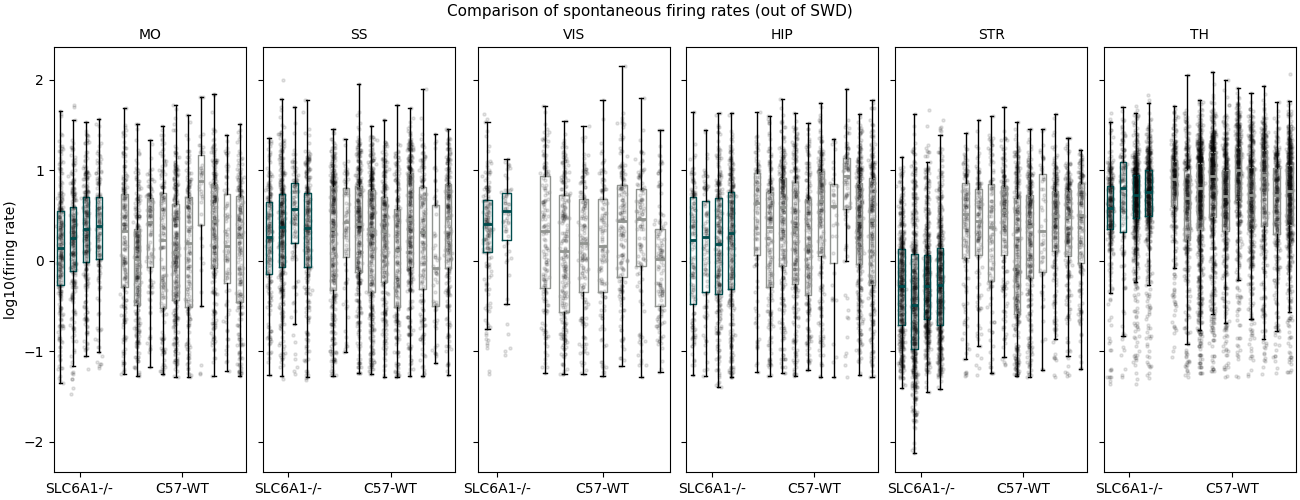

In [45]:
pregions = ['MO', 'SS', 'VIS', 'HIP', 'STR', 'TH']
genotype_palette = {"SLC6A1-/-": "xkcd:dark teal", "C57-WT": "xkcd:grey"}

fig, axs = plt.subplots(1, len(pregions), figsize=(13,5), constrained_layout=True, sharey=True)
for ax, pregi in zip(axs, pregions):
    regdf = all_select_units[all_select_units['parent_region'] == pregi]
    xpos = np.arange(len(np.unique(regdf.mouse.values)))
    genotype_meds = []
    xpos = 0
    xticklocs = []
    for gi, (geni, gcol) in enumerate(genotype_palette.items()):
        genodf = regdf[regdf['genotype'] == geni]
        subject_meds = []
        xpos += gi
        xpositions = []
        for mousei in np.unique(genodf.mouse.values):
            subdf = genodf[genodf['mouse'] == mousei]
            xs = np.random.normal(xpos, 0.1, len(subdf))
            ax.boxplot(
                subdf.log10spFRoutSWD.values, positions=[xpos], widths=0.5, showfliers=False,
                medianprops={'color': gcol, 'linewidth': 2}, boxprops={'color': gcol}
            )
            ax.scatter(xs, subdf.log10spFRoutSWD.values, c='k', marker='o', s=5, alpha=0.1)
            subject_meds.append(np.median(subdf.log10spFRoutSWD.values))
            xpositions.append(xpos)
            xpos += 1
        genotype_meds.append(subject_meds)
        xticklocs.append(np.mean(xpositions))
    ax.set_xlabel('')
    ax.set_title(pregi)
    ax.set_xticks(xticklocs)
    ax.set_xticklabels(genotype_palette.keys())
fig.suptitle('Comparison of spontaneous firing rates (out of SWD)', fontsize=11)
axs[0].set_ylabel('log10(firing rate)')

## Save ##
figname = 'multisub_SLC-WT_spontFR_outSWDonly_allmajorregions_{}.png'.format(date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotdir, figname), transparent=False, dpi=150)

In [48]:
pregion = 'VIS'
# genotype_order = ['SLC6A1-/-', 'C57-WT']
# fig, axs = plt.subplots(1, 3, figsize=(6,4), constrained_layout=True, sharey=True)
# fig, ax = plt.subplots(figsize=(6,4), constrained_layout=True)
regdf = all_select_units[all_select_units['parent_region'] == pregion]
# sns.swarmplot(data=regdf, x='genotype', y='log10spFRoutSWD', order=genotype_order, color='k', ax=ax, alpha=1.0, size=1.0)
# xwidth = 0.1
# for gi, geni in enumerate(genotype_order):
#     genodf = regdf[regdf['genotype'] == geni]
#     xvals = np.arange(len(np.unique(genodf.mouse.values))) * xwidth
#     xpos = gi - (np.mean(xvals) - xvals)
#     for xposi, mousei in zip(xpos, np.unique(genodf.mouse.values)):
#         subdf = genodf[genodf['mouse'] == mousei]
#         ax.boxplot(subdf.log10spFRoutSWD.values, positions=[xposi], widths=xwidth, showfliers=False)
# ax.set_xticks(np.arange(len(genotype_order)))
# ax.set_xticklabels(genotype_order)
# ax.set_xlabel('Genotype')
# ax.set_title(pregion)
# ax.set_ylabel('log10(firing rate)')
# fig.suptitle('Comparison of spontaneous firing rates (out of SWD)', fontsize=10)

## Linear mixed model ##
lmm = smf.mixedlm(formula="log10spFRoutSWD ~ genotype", data=regdf, groups=regdf['mouse']).fit()
print(lmm.summary())

            Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: log10spFRoutSWD
No. Observations:  1270    Method:             REML           
No. Groups:        9       Scale:              0.4500         
Min. group size:   59      Log-Likelihood:     -1304.5047     
Max. group size:   222     Converged:          Yes            
Mean group size:   141.1                                      
--------------------------------------------------------------
                      Coef. Std.Err.   z   P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept             0.181    0.046 3.922 0.000  0.091  0.272
genotype[T.SLC6A1-/-] 0.179    0.102 1.746 0.081 -0.022  0.379
Group Var             0.012    0.012                          



In [77]:
lmm.pvalues

Intercept                2.152390e-15
genotype[T.SLC6A1-/-]    4.263580e-18
Group Var                2.724617e-02
dtype: float64

In [55]:
180 / 25.4

7.086614173228347

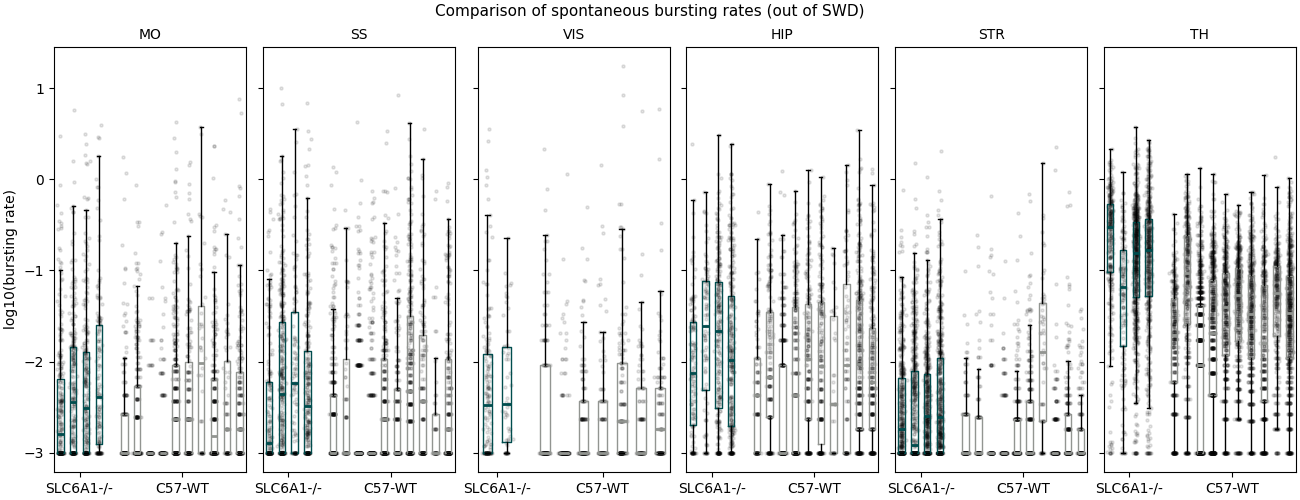

In [54]:
## Spont BR ##
pregions = ['MO', 'SS', 'VIS', 'HIP', 'STR', 'TH']
genotype_palette = {"SLC6A1-/-": "xkcd:dark teal", "C57-WT": "xkcd:grey"}

fig, axs = plt.subplots(1, len(pregions), figsize=(13,5), constrained_layout=True, sharey=True)
for ax, pregi in zip(axs, pregions):
    regdf = all_select_units[all_select_units['parent_region'] == pregi]
    xpos = np.arange(len(np.unique(regdf.mouse.values)))
    genotype_meds = []
    xpos = 0
    xticklocs = []
    for gi, (geni, gcol) in enumerate(genotype_palette.items()):
        genodf = regdf[regdf['genotype'] == geni]
        subject_meds = []
        xpos += gi
        xpositions = []
        for mousei in np.unique(genodf.mouse.values):
            subdf = genodf[genodf['mouse'] == mousei]
            xs = np.random.normal(xpos, 0.1, len(subdf))
            ax.boxplot(
                subdf.log10spBRoutSWD.values, positions=[xpos], widths=0.5, showfliers=False,
                medianprops={'color': gcol, 'linewidth': 2}, boxprops={'color': gcol}
            )
            ax.scatter(xs, subdf.log10spBRoutSWD.values, c='k', marker='o', s=5, alpha=0.1)
            subject_meds.append(np.median(subdf.log10spBRoutSWD.values))
            xpositions.append(xpos)
            xpos += 1
        genotype_meds.append(subject_meds)
        xticklocs.append(np.mean(xpositions))
    ax.set_xlabel('')
    ax.set_title(pregi)
    ax.set_xticks(xticklocs)
    ax.set_xticklabels(genotype_palette.keys())
fig.suptitle('Comparison of spontaneous bursting rates (out of SWD)', fontsize=11)
axs[0].set_ylabel('log10(bursting rate)')

## Save ##
figname = 'multisub_SLC-WT_spontBR_outSWDonly_allmajorregions_{}.png'.format(date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotdir, figname), transparent=False, dpi=150)

In [53]:
pregion = 'VIS'
regdf = all_select_units[all_select_units['parent_region'] == pregion]

## Linear mixed model ##
lmm = smf.mixedlm(formula="log10spBRoutSWD ~ genotype", data=regdf, groups=regdf['mouse']).fit()
print(lmm.summary())

              Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  log10spBRoutSWD
No. Observations:   1270     Method:              REML           
No. Groups:         9        Scale:               0.4289         
Min. group size:    59       Log-Likelihood:      -1274.7642     
Max. group size:    222      Converged:           Yes            
Mean group size:    141.1                                        
-----------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept             -2.614    0.050 -52.046 0.000 -2.712 -2.515
genotype[T.SLC6A1-/-]  0.316    0.110   2.868 0.004  0.100  0.532
Group Var              0.015    0.014                            



#### For cortical regions, split into RS/FS

In [56]:
pregions = ['MO', 'SS', 'VIS'] # , 'HIP']
pselect = []
for pregi in pregions:
    pselect.append(all_select_units[all_select_units['parent_region'] == pregi])
parentdf = pd.concat(pselect, ignore_index=True)
print(np.unique(parentdf['parent_region'].values))

['MO' 'SS' 'VIS']


In [57]:
layer = []
for subregi in parentdf['region'].values:
    if isinstance(subregi, str):
        if '1' in subregi:
            layer.append('1')
        elif '2/3' in subregi:
            layer.append('2/3')
        elif '4' in subregi:
            layer.append('4')
        elif '5' in subregi:
            layer.append('5')
        elif '6' in subregi:
            layer.append('6')
        else:
            layer.append('none')
    else:
        layer.append('none')
parentdf['layer'] = layer

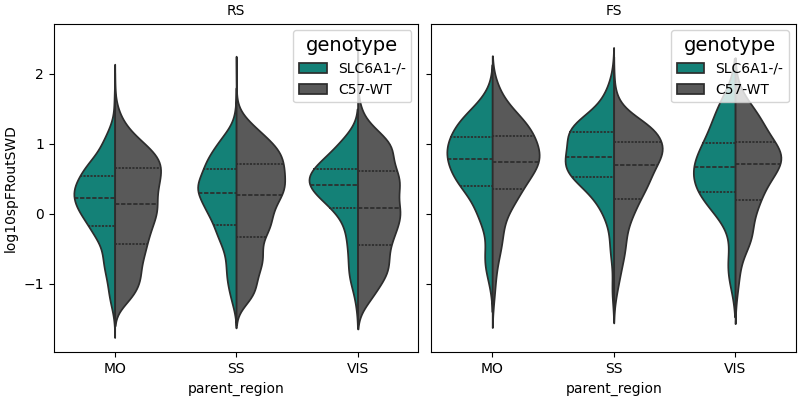

In [81]:
plot_celltypes = ['RS', 'FS']
fig, axs = plt.subplots(1, 2, figsize=(8,4), constrained_layout=True, sharey=True)

for axi, plot_ct in enumerate(plot_celltypes):
    plotdf = parentdf[parentdf['cell_type'] == plot_ct]
    sns.violinplot(
        data=plotdf, x="parent_region", y="log10spFRoutSWD", hue='genotype',
        split=True, inner="quart", palette={"SLC6A1-/-": "xkcd:dark teal", "C57-WT": "xkcd:grey"}, ax=axs[axi]
    )
    axs[axi].set_title(plot_ct)
## Save ##
figname = 'multisub_SLC-WT_spontFR_cortex_allct_{}.png'.format(date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotdir, figname), transparent=False, dpi=150)

Text(0.5, 0.98, 'Spontaneous burst rate (out only)')

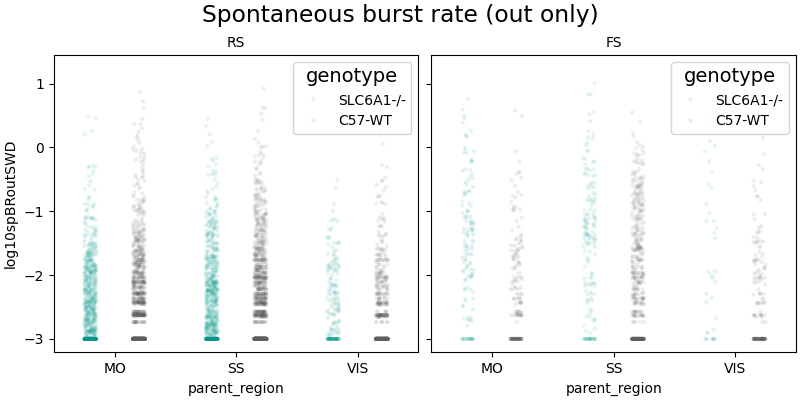

In [45]:
plot_celltypes = ['RS', 'FS']
fig, axs = plt.subplots(1, 2, figsize=(8,4), constrained_layout=True, sharey=True)

for axi, plot_ct in enumerate(plot_celltypes):
    plotdf = parentdf[parentdf['cell_type'] == plot_ct]
    sns.stripplot(
        data=plotdf, x="parent_region", y="log10spBRoutSWD", hue='genotype',
        dodge=True, palette={"SLC6A1-/-": "xkcd:dark teal", "C57-WT": "xkcd:grey"}, alpha=0.1, size=3.0, ax=axs[axi]
    )
    axs[axi].set_title(plot_ct)

fig.suptitle('Spontaneous burst rate (out only)')
## Save ##
# figname = 'multisub_SLC-WT_spontFR_cortex_allct_{}.png'.format(date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotdir, figname), transparent=False, dpi=150)

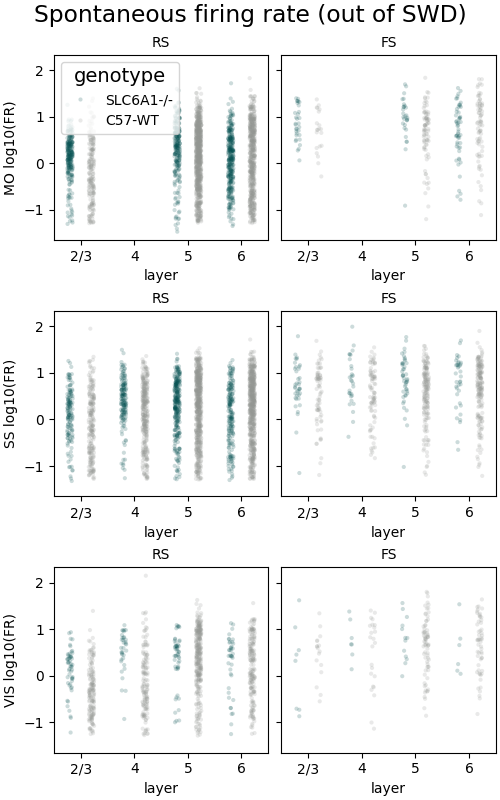

In [58]:
## Separate by layer ##
pregions = ['MO', 'SS', 'VIS']
plot_celltypes = ['RS', 'FS']
plot_layers = ['2/3', '4', '5', '6']
fig, axs = plt.subplots(len(pregions), len(plot_celltypes), figsize=(5,8), constrained_layout=True, sharey=True)
for rowi, parenti in enumerate(pregions):
    for coli, cti in enumerate(plot_celltypes):
        plotdf = all_select_units[(all_select_units['parent_region'] == parenti) & (all_select_units['cell_type'] == cti)]
        if (rowi == 0) & (coli == 0):
            sns.stripplot(
                data=plotdf, x="layer", y="log10spFRoutSWD", hue='genotype', order=plot_layers,
                dodge=True, palette={"SLC6A1-/-": "xkcd:dark teal", "C57-WT": "xkcd:grey"}, alpha=0.2, size=3.0, ax=axs[rowi,coli]
            )
        else:
            sns.stripplot(
                data=plotdf, x="layer", y="log10spFRoutSWD", hue='genotype', order=plot_layers,
                dodge=True, palette={"SLC6A1-/-": "xkcd:dark teal", "C57-WT": "xkcd:grey"}, alpha=0.2, size=3.0, ax=axs[rowi,coli], legend=False
            )
        axs[rowi,coli].set_title('{}'.format(cti))
    axs[rowi,0].set_ylabel('{} log10(FR)'.format(parenti))
fig.suptitle('Spontaneous firing rate (out of SWD)')
## Save ##
figname = 'multisub_SLC-WT_spontFR_cortex_layer_{}.png'.format(date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotdir, figname), transparent=False, dpi=150)

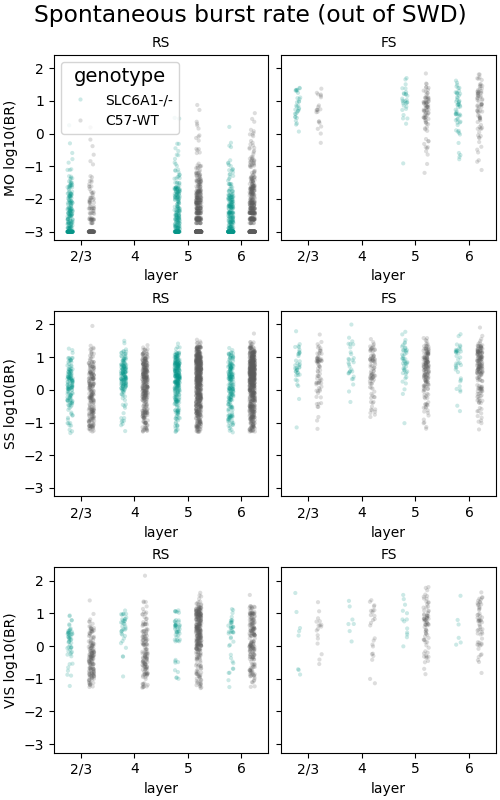

In [72]:
## Separate by layer ##
pregions = ['MO', 'SS', 'VIS']
plot_celltypes = ['RS', 'FS']
plot_layers = ['2/3', '4', '5', '6']
fig, axs = plt.subplots(len(pregions), len(plot_celltypes), figsize=(5,8), constrained_layout=True, sharey=True)
for rowi, parenti in enumerate(pregions):
    for coli, cti in enumerate(plot_celltypes):
        plotdf = all_select_units[(all_select_units['parent_region'] == parenti) & (all_select_units['cell_type'] == cti)]
        if (rowi == 0) & (coli == 0):
            sns.stripplot(
                data=plotdf, x="layer", y="log10spBRoutSWD", hue='genotype', order=plot_layers,
                dodge=True, palette={"SLC6A1-/-": "xkcd:dark teal", "C57-WT": "xkcd:grey"}, alpha=0.2, size=3.0, ax=axs[rowi,coli]
            )
        else:
            sns.stripplot(
                data=plotdf, x="layer", y="log10spFRoutSWD", hue='genotype', order=plot_layers,
                dodge=True, palette={"SLC6A1-/-": "xkcd:dark teal", "C57-WT": "xkcd:grey"}, alpha=0.2, size=3.0, ax=axs[rowi,coli], legend=False
            )
        axs[rowi,coli].set_title('{}'.format(cti))
    axs[rowi,0].set_ylabel('{} log10(BR)'.format(parenti))
fig.suptitle('Spontaneous burst rate (out of SWD)')
## Save ##
figname = 'multisub_SLC-WT_spontBR_cortex_layer_{}.png'.format(date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotdir, figname), transparent=False, dpi=150)

#### For striatum

In [23]:
pregions = ['STR']
pselect = []
for pregi in pregions:
    pselect.append(all_select_units[all_select_units['parent_region'] == pregi])
parentdf = pd.concat(pselect, ignore_index=True)
print(np.unique(parentdf['parent_region'].values))
print(np.unique(parentdf['region'].values))
print(len(parentdf))

['STR']
['CP' 'LSr' 'LSv' 'SH' 'STR' 'VL' 'ccb' 'ccg' 'fa' 'fiber tracts' 'or'
 'st']
4163


In [82]:
region = 'CP'
regidf = all_select_units[all_select_units['region'] == region]
print(np.unique(regidf['cell_type'].values))
print(len(regidf))

['FSI' 'MSN' 'TAN' 'UIN']
2404


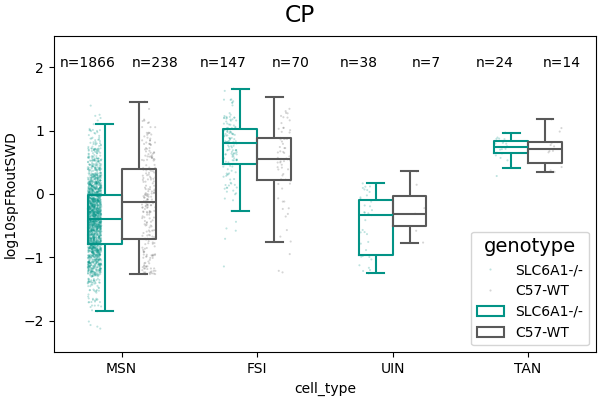

In [97]:
fig, ax = plt.subplots(figsize=(6,4), constrained_layout=True)
sns.stripplot(
    data=regidf, x="cell_type", y="log10spFRoutSWD", hue="genotype",
    dodge=True, palette={"SLC6A1-/-": "xkcd:dark teal", "C57-WT": "xkcd:grey"}, alpha=0.25, size=1.5, ax=ax
)
sns.boxplot(
    data=regidf, x="cell_type", y="log10spFRoutSWD", hue="genotype",
    dodge=True, palette={"SLC6A1-/-": "xkcd:dark teal", "C57-WT": "xkcd:grey"}, ax=ax, fill=False, showfliers=False, width=0.5
)
ax.set_ylim([-2.5, 2.5])
unit_counts = regidf.groupby(['cell_type','genotype']).size()
ypos = 2.0
ax.annotate('n={:d}'.format(unit_counts['MSN']['SLC6A1-/-']), xy=(-0.25, ypos), fontsize=10, ha='center')
ax.annotate('n={:d}'.format(unit_counts['MSN']['C57-WT']), xy=(0.25, ypos), fontsize=10, ha='center')
ax.annotate('n={:d}'.format(unit_counts['FSI']['SLC6A1-/-']), xy=(0.75, ypos), fontsize=10, ha='center')
ax.annotate('n={:d}'.format(unit_counts['FSI']['C57-WT']), xy=(1.25, ypos), fontsize=10, ha='center')
ax.annotate('n={:d}'.format(unit_counts['UIN']['SLC6A1-/-']), xy=(1.75, ypos), fontsize=10, ha='center')
ax.annotate('n={:d}'.format(unit_counts['UIN']['C57-WT']), xy=(2.25, ypos), fontsize=10, ha='center')
ax.annotate('n={:d}'.format(unit_counts['TAN']['SLC6A1-/-']), xy=(2.75, ypos), fontsize=10, ha='center')
ax.annotate('n={:d}'.format(unit_counts['TAN']['C57-WT']), xy=(3.25, ypos), fontsize=10, ha='center')
fig.suptitle(region)
## Save ##
figname = 'multisub_SLC-WT_spontFR_{}allct_{}.png'.format(region, date.today().strftime('%b%d%Y'))
fig.savefig(os.path.join(plotdir, figname), transparent=False, dpi=150)

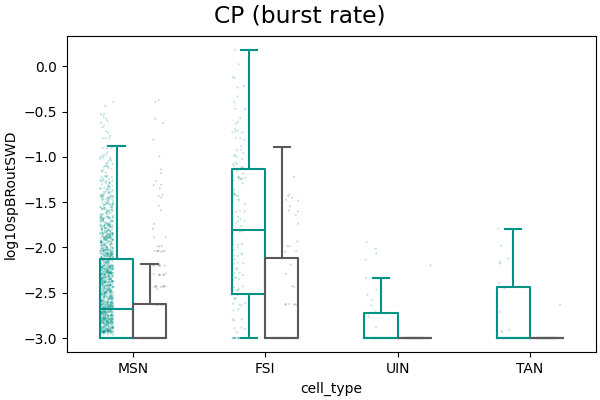

In [102]:
fig, ax = plt.subplots(figsize=(6,4), constrained_layout=True)
sns.stripplot(
    data=regidf, x="cell_type", y="log10spBRoutSWD", hue="genotype",
    dodge=True, palette={"SLC6A1-/-": "xkcd:dark teal", "C57-WT": "xkcd:grey"}, alpha=0.25, size=1.5, ax=ax, legend=False
)
sns.boxplot(
    data=regidf, x="cell_type", y="log10spBRoutSWD", hue="genotype",
    dodge=True, palette={"SLC6A1-/-": "xkcd:dark teal", "C57-WT": "xkcd:grey"}, ax=ax, fill=False, showfliers=False, width=0.5, legend=False
)
unit_counts = regidf.groupby(['cell_type','genotype']).size()
ypos = 0.5
ax.annotate('n={:d}'.format(unit_counts['MSN']['SLC6A1-/-']), xy=(-0.25, ypos), fontsize=10, ha='center')
ax.annotate('n={:d}'.format(unit_counts['MSN']['C57-WT']), xy=(0.25, ypos), fontsize=10, ha='center')
ax.annotate('n={:d}'.format(unit_counts['FSI']['SLC6A1-/-']), xy=(0.75, ypos), fontsize=10, ha='center')
ax.annotate('n={:d}'.format(unit_counts['FSI']['C57-WT']), xy=(1.25, ypos), fontsize=10, ha='center')
ax.annotate('n={:d}'.format(unit_counts['UIN']['SLC6A1-/-']), xy=(1.75, ypos), fontsize=10, ha='center')
ax.annotate('n={:d}'.format(unit_counts['UIN']['C57-WT']), xy=(2.25, ypos), fontsize=10, ha='center')
ax.annotate('n={:d}'.format(unit_counts['TAN']['SLC6A1-/-']), xy=(2.75, ypos), fontsize=10, ha='center')
ax.annotate('n={:d}'.format(unit_counts['TAN']['C57-WT']), xy=(3.25, ypos), fontsize=10, ha='center')
fig.suptitle('{} (burst rate)'.format(region))
## Save ##
figname = 'multisub_SLC-WT_spontBR_{}allct_{}.png'.format(region, date.today().strftime('%b%d%Y'))
fig.savefig(os.path.join(plotdir, figname), transparent=False, dpi=150)

### For thalamus

In [36]:
region = 'RT'
regidf = all_select_units[all_select_units['region'] == region]
print(np.unique(regidf['parent_region'].values))
print(np.unique(regidf['cell_type'].values))
print(len(regidf))

['TH']
['TC' 'pRT']
586


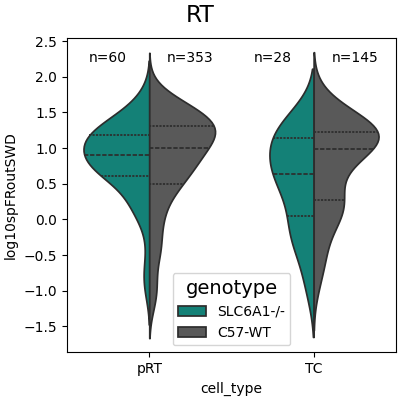

In [76]:
fig, ax = plt.subplots(figsize=(4,4), constrained_layout=True)
vplot = sns.violinplot(
    data=regidf, x="cell_type", y="log10spFRoutSWD", hue="genotype",
    split=True, inner="quart", palette={"SLC6A1-/-": "xkcd:dark teal", "C57-WT": "xkcd:grey"}, ax=ax
)
unit_counts = regidf.groupby(['cell_type','genotype']).size()
ypos = 2.2
ax.annotate('n={:d}'.format(unit_counts['pRT']['SLC6A1-/-']), xy=(-0.25, ypos), fontsize=10, ha='center')
ax.annotate('n={:d}'.format(unit_counts['pRT']['C57-WT']), xy=(0.25, ypos), fontsize=10, ha='center')
ax.annotate('n={:d}'.format(unit_counts['TC']['SLC6A1-/-']), xy=(0.75, ypos), fontsize=10, ha='center')
ax.annotate('n={:d}'.format(unit_counts['TC']['C57-WT']), xy=(1.25, ypos), fontsize=10, ha='center')
fig.suptitle(region)
## Save ##
figname = 'multisub_SLC-WT_spontFR_{}allct_{}.png'.format(region, date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotdir, figname), transparent=False, dpi=150)

All thalamic regions

In [90]:
HY_regions = ['FF', 'HY', 'ZI']
otherFT = ['root','alv','ar','ccb','cing','em','fi','fiber tracts','fp','int','lfbs','ml','or','scwm','st','VL'] # VL is lateral ventricle
pselect = []
for pregi in np.unique(all_select_units[all_select_units['parent_region'] == 'TH'].region.values):
    if pregi in HY_regions:
        print('{} in hypothalamus'.format(pregi))
        continue
    if pregi in otherFT:
        print('{} is other/fiber tract'.format(pregi))
        continue
    pselect.append(all_select_units[all_select_units['region'] == pregi])
parentdf = pd.concat(pselect, ignore_index=True)
print(np.unique(parentdf['cell_type'].values))
print(np.unique(parentdf['region'].values))
print(len(parentdf))

FF in hypothalamus
HY in hypothalamus
VL is other/fiber tract
ZI in hypothalamus
alv is other/fiber tract
em is other/fiber tract
fi is other/fiber tract
fiber tracts is other/fiber tract
int is other/fiber tract
ml is other/fiber tract
or is other/fiber tract
root is other/fiber tract
st is other/fiber tract
['TC' 'pRT']
['AD' 'AMd' 'AMv' 'AV' 'CL' 'Eth' 'IAD' 'LD' 'LGd-co' 'LGd-sh' 'LGv' 'LP'
 'MD' 'MGd' 'MGm' 'MGv' 'PCN' 'PIL' 'PO' 'POL' 'PoT' 'RT' 'SGN' 'TH' 'VAL'
 'VPL' 'VPM']
6444


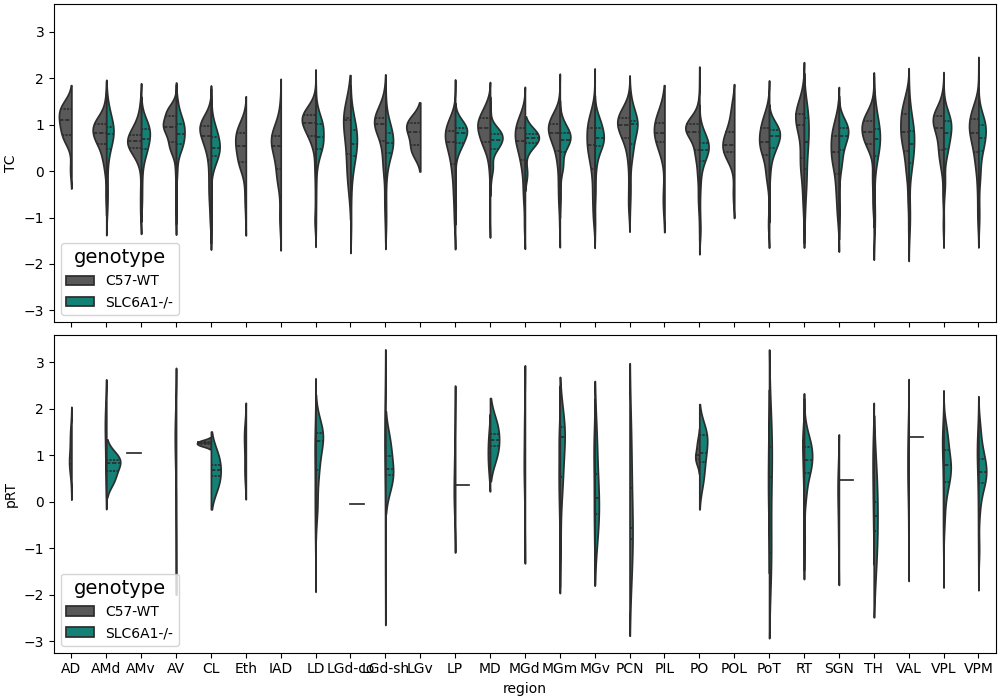

In [95]:
plot_celltypes = ['TC', 'pRT']
fig, axs = plt.subplots(2, 1, figsize=(10,7), constrained_layout=True, sharex=True, sharey=True)

for axi, plot_ct in enumerate(plot_celltypes):
    plotdf = parentdf[parentdf['cell_type'] == plot_ct]
    sns.violinplot(
        data=plotdf, x="region", y="log10spFRoutSWD", hue='genotype',
        split=True, inner="quart", palette={"SLC6A1-/-": "xkcd:dark teal", "C57-WT": "xkcd:grey"}, ax=axs[axi]
    )
    axs[axi].set_ylabel(plot_ct)
## Save ##
figname = 'multisub_SLC-WT_spontFR_TH_allct_{}.png'.format(date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotdir, figname), transparent=False, dpi=150)

In [103]:
## Want to split into first- vs. higher-order ##
TH_mesogroups = {
    # 'X': ['null','root','nan'],
    # 'FT': ['alv','ar','ccb','cing','em','fi','fiber tracts','fp','int','lfbs','ml','or','scwm','st','VL'], # VL is lateral ventricle
    'RT': ['RT'],
    # 'HY': ['FF','HY','LZ','ME','MEZ','ZI','PVZ','PVR'],
    # 'AD': ['AD'], # no AD in the SCL recordings, no RE in any recordings
    'TH_FO': ['LGd','LGd-co','LGd-ip','LGd-sh','VPL','VPM','MGv','LGN','LGv','VPMpc'],
    'TH_HO': ['LP','PO','MGd','MGm','MD','AM','AV','RE','VAL','LD','CL','CM','PF','Eth','VM','AMd','AMv','IMD','MG','PCN','PVT','SMT'],
    'TH_other': ['TH','SPA','LH','MH','PIL','POL','PoT','SGN','SPFm','SPFp','IAD'],
}

pselect = []
mregs = []
for regi in np.unique(all_select_units[all_select_units['parent_region'] == 'TH'].region.values):
    for mregi, reglist in TH_mesogroups.items():
        if regi in reglist:
            tdf = all_select_units[all_select_units['region'] == regi]
            pselect.append(tdf)
            mregs.append([mregi] * len(tdf))
            break
            
parentdf = pd.concat(pselect, ignore_index=True)
parentdf['mesoregion'] = np.concatenate(mregs)
print(np.unique(parentdf['cell_type'].values))
print(np.unique(parentdf['region'].values))
print(len(parentdf))

['TC' 'pRT']
['AMd' 'AMv' 'AV' 'CL' 'Eth' 'IAD' 'LD' 'LGd-co' 'LGd-sh' 'LGv' 'LP' 'MD'
 'MGd' 'MGm' 'MGv' 'PCN' 'PIL' 'PO' 'POL' 'PoT' 'RT' 'SGN' 'TH' 'VAL'
 'VPL' 'VPM']
6409


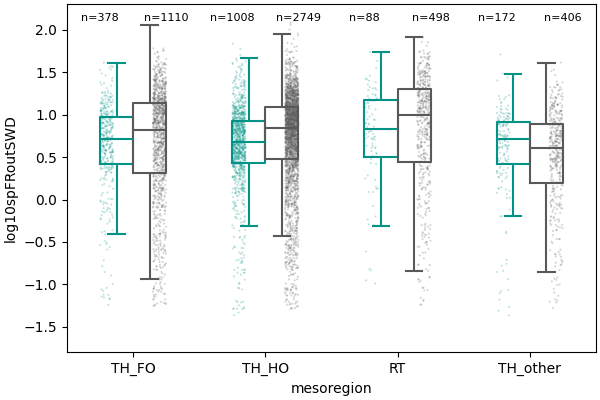

In [117]:
plot_order = ['TH_FO', 'TH_HO', 'RT', 'TH_other']
fig, ax = plt.subplots(figsize=(6,4), constrained_layout=True)
sns.stripplot(
    data=parentdf, x="mesoregion", y="log10spFRoutSWD", hue="genotype", order=plot_order,
    dodge=True, palette={"SLC6A1-/-": "xkcd:dark teal", "C57-WT": "xkcd:grey"}, alpha=0.25, size=1.5, ax=ax, legend=False
)
sns.boxplot(
    data=parentdf, x="mesoregion", y="log10spFRoutSWD", hue="genotype", order=plot_order,
    dodge=True, palette={"SLC6A1-/-": "xkcd:dark teal", "C57-WT": "xkcd:grey"}, ax=ax, fill=False, showfliers=False, width=0.5, legend=False
)
ax.set_ylim([-1.8,2.3])
# ax.set_ylabel(plot_ct)
# ax.legend(loc=1)
unit_counts = parentdf.groupby(['mesoregion','genotype']).size()
ypos = 2.1
ax.annotate('n={:d}'.format(unit_counts['TH_FO']['SLC6A1-/-']), xy=(-0.25, ypos), fontsize=8, ha='center')
ax.annotate('n={:d}'.format(unit_counts['TH_FO']['C57-WT']), xy=(0.25, ypos), fontsize=8, ha='center')
ax.annotate('n={:d}'.format(unit_counts['TH_HO']['SLC6A1-/-']), xy=(0.75, ypos), fontsize=8, ha='center')
ax.annotate('n={:d}'.format(unit_counts['TH_HO']['C57-WT']), xy=(1.25, ypos), fontsize=8, ha='center')
ax.annotate('n={:d}'.format(unit_counts['RT']['SLC6A1-/-']), xy=(1.75, ypos), fontsize=8, ha='center')
ax.annotate('n={:d}'.format(unit_counts['RT']['C57-WT']), xy=(2.25, ypos), fontsize=8, ha='center')
ax.annotate('n={:d}'.format(unit_counts['TH_other']['SLC6A1-/-']), xy=(2.75, ypos), fontsize=8, ha='center')
ax.annotate('n={:d}'.format(unit_counts['TH_other']['C57-WT']), xy=(3.25, ypos), fontsize=8, ha='center')
## Save ##
figname = 'multisub_SLC-WT_spontFR_TH_mregions_{}.png'.format(date.today().strftime('%b%d%Y'))
fig.savefig(os.path.join(plotdir, figname), transparent=False, dpi=150)

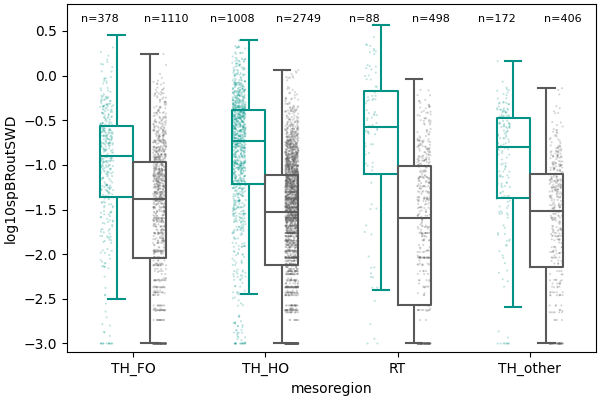

In [119]:
plot_order = ['TH_FO', 'TH_HO', 'RT', 'TH_other']
fig, ax = plt.subplots(figsize=(6,4), constrained_layout=True)
sns.stripplot(
    data=parentdf, x="mesoregion", y="log10spBRoutSWD", hue="genotype", order=plot_order,
    dodge=True, palette={"SLC6A1-/-": "xkcd:dark teal", "C57-WT": "xkcd:grey"}, alpha=0.25, size=1.5, ax=ax, legend=False
)
sns.boxplot(
    data=parentdf, x="mesoregion", y="log10spBRoutSWD", hue="genotype", order=plot_order,
    dodge=True, palette={"SLC6A1-/-": "xkcd:dark teal", "C57-WT": "xkcd:grey"}, ax=ax, fill=False, showfliers=False, width=0.5, legend=False
)
ax.set_ylim([-3.1,0.8])
# ax.set_ylabel(plot_ct)
# ax.legend(loc=1)
unit_counts = parentdf.groupby(['mesoregion','genotype']).size()
ypos = 0.6
ax.annotate('n={:d}'.format(unit_counts['TH_FO']['SLC6A1-/-']), xy=(-0.25, ypos), fontsize=8, ha='center')
ax.annotate('n={:d}'.format(unit_counts['TH_FO']['C57-WT']), xy=(0.25, ypos), fontsize=8, ha='center')
ax.annotate('n={:d}'.format(unit_counts['TH_HO']['SLC6A1-/-']), xy=(0.75, ypos), fontsize=8, ha='center')
ax.annotate('n={:d}'.format(unit_counts['TH_HO']['C57-WT']), xy=(1.25, ypos), fontsize=8, ha='center')
ax.annotate('n={:d}'.format(unit_counts['RT']['SLC6A1-/-']), xy=(1.75, ypos), fontsize=8, ha='center')
ax.annotate('n={:d}'.format(unit_counts['RT']['C57-WT']), xy=(2.25, ypos), fontsize=8, ha='center')
ax.annotate('n={:d}'.format(unit_counts['TH_other']['SLC6A1-/-']), xy=(2.75, ypos), fontsize=8, ha='center')
ax.annotate('n={:d}'.format(unit_counts['TH_other']['C57-WT']), xy=(3.25, ypos), fontsize=8, ha='center')
## Save ##
figname = 'multisub_SLC-WT_spontBR_TH_mregions_{}.png'.format(date.today().strftime('%b%d%Y'))
fig.savefig(os.path.join(plotdir, figname), transparent=False, dpi=150)

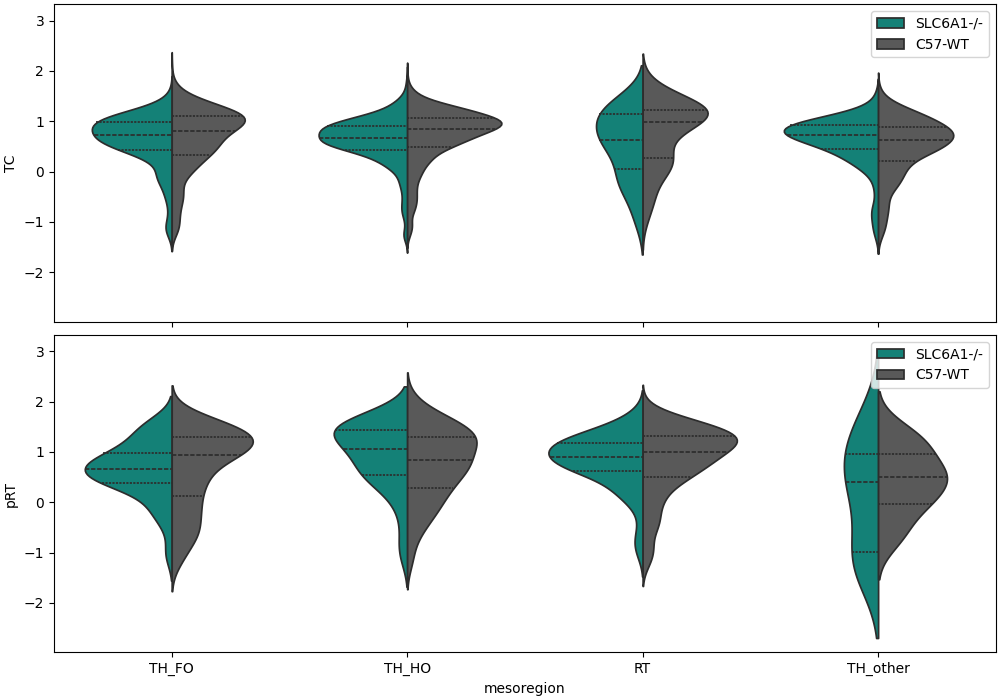

In [107]:
plot_celltypes = ['TC', 'pRT']
plot_order = ['TH_FO', 'TH_HO', 'RT', 'TH_other']
fig, axs = plt.subplots(2, 1, figsize=(10,7), constrained_layout=True, sharex=True, sharey=True)

for axi, plot_ct in enumerate(plot_celltypes):
    plotdf = parentdf[parentdf['cell_type'] == plot_ct]
    sns.violinplot(
        data=plotdf, x="mesoregion", y="log10spFRoutSWD", hue='genotype', order=plot_order,
        split=True, inner="quart", palette={"SLC6A1-/-": "xkcd:dark teal", "C57-WT": "xkcd:grey"}, ax=axs[axi]
    )
    axs[axi].set_ylabel(plot_ct)
    axs[axi].legend(loc=1)
    unit_counts = plotdf.groupby(['mesoregion','genotype']).size()
    ypos = -1
    # axs[axi].annotate('n={:d}'.format(unit_counts['TH_secondary']['SLC6A1-/-']), xy=(-0.25, ypos), fontsize=10, ha='center')
    # axs[axi].annotate('n={:d}'.format(unit_counts['TH_secondary']['C57-WT']), xy=(0.25, ypos), fontsize=10, ha='center')
    # axs[axi].annotate('n={:d}'.format(unit_counts['TH_primary']['SLC6A1-/-']), xy=(0.75, ypos), fontsize=10, ha='center')
    # axs[axi].annotate('n={:d}'.format(unit_counts['TH_primary']['C57-WT']), xy=(1.25, ypos), fontsize=10, ha='center')
    # axs[axi].annotate('n={:d}'.format(unit_counts['TH_tertiary']['SLC6A1-/-']), xy=(1.75, ypos), fontsize=10, ha='center')
    # axs[axi].annotate('n={:d}'.format(unit_counts['TH_tertiary']['C57-WT']), xy=(2.25, ypos), fontsize=10, ha='center')
    # axs[axi].annotate('n={:d}'.format(unit_counts['TH_other']['SLC6A1-/-']), xy=(2.75, ypos), fontsize=10, ha='center')
    # axs[axi].annotate('n={:d}'.format(unit_counts['TH_other']['C57-WT']), xy=(3.25, ypos), fontsize=10, ha='center')
    # axs[axi].annotate('n={:d}'.format(unit_counts['RT']['SLC6A1-/-']), xy=(3.75, ypos), fontsize=10, ha='center')
    # axs[axi].annotate('n={:d}'.format(unit_counts['RT']['C57-WT']), xy=(4.25, ypos), fontsize=10, ha='center')
## Save ##
figname = 'multisub_SLC-WT_spontFR_TH_mregions_{}.png'.format(date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotdir, figname), transparent=False, dpi=150)

# For SLC mice, look at firing in/out of SWD

In [22]:
SLC_df = all_select_units[all_select_units['genotype'] == 'SLC6A1-/-']
print(len(SLC_df))

7457


In [23]:
SLC_df.head()

unit_id   probe  peak_ch  depth  spike_duration region  CCF_AP  CCF_DV  \
0      B0  probeB        0   3640        0.467002    VAL     258     151   
1      B1  probeB        0   3640        0.453266    VAL     258     151   
2      B2  probeB        0   3640        0.439531    VAL     258     151   
3      B3  probeB        2   3620        0.508208    VAL     258     150   
4      B4  probeB        1   3640        0.425796    VAL     258     150   

   CCF_ML  firing_rate  presence_ratio  isi_viol  amplitude_cutoff  \
0     176    12.807218            0.99  0.009902          0.000319   
1     176     0.971066            0.99  2.447504          0.192962   
2     176     2.587761            0.99  0.395704          0.500000   
3     176     2.201205            0.99  0.758586          0.500000   
4     176     2.222870            0.99  0.743871          0.500000   

   spike_count parent_region   spont_FR  spont_BR  burst_ratio  \
0        56158            TH  14.950864  0.189088     0.024674   
1         4258            TH   1.204338  0.025415     0.038245   
2        11347            TH   2.271772  0.071162     0.054993   
3         9652            TH   1.723145  0.036259     0.036753   
4         9747            TH   2.158251  0.054219     0.045504   

   spont_FR_outSWD  spont_FR_inSWD  spont_BR_outSWD  spont_BR_inSWD   mouse  \
0        12.601556       14.128526         0.100517        0.343347  645606   
1         0.865998        1.295908         0.008311        0.031584  645606   
2         2.126952        2.188854         0.046437        0.085127  645606   
3         1.462355        1.654395         0.012239        0.053019  645606   
4         1.929053        1.969954         0.032180        0.070480  645606   

                 exp   genotype  bc_ps_supp_ms  bc_proplongisi cell_type  \
0  EEGNPXspont_estim  SLC6A1-/-            3.0        0.000534        TC   
1  EEGNPXspont_estim  SLC6A1-/-            1.0        0.134602        TC   
2  EEGNPXspont_estim  SLC6A1-/-            1.0        0.013044        TC   
3  EEGNPXspont_estim  SLC6A1-/-            1.0        0.025075        TC   
4  EEGNPXspont_estim  SLC6A1-/-            1.0        0.020829        TC   

   log10spFR  log10spBR  log10spFRoutSWD  log10spFRinSWD  log10spBRoutSWD  \
0   1.174695  -0.721044         1.100459        1.150128        -0.993460   
1   0.081109  -1.578148        -0.061982        0.112909        -2.031001   
2   0.356556  -1.141690         0.327962        0.340415        -1.323882   
3   0.236574  -1.428770         0.165350        0.218902        -1.878135   
4   0.334303  -1.257912         0.285569        0.294676        -1.479119   

   log10spBRinSWD layer  
0       -0.463003  none  
1       -1.486992  none  
2       -1.064862  none  
3       -1.267456  none  
4       -1.145815  none

In [24]:
iocolor = {'in': 'xkcd:pumpkin', 'out': 'xkcd:dark teal'}

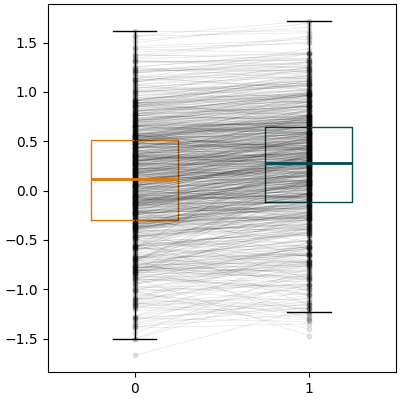

In [33]:
pregion = 'MO'
plot_metrics = {'in': 'log10spFRinSWD', 'out': 'log10spFRoutSWD'}
pregdf = SLC_df[SLC_df['parent_region'] == pregion]
fig, ax = plt.subplots(figsize=(4,4), constrained_layout=True)
iovals = []
for ii, (pio, meti) in enumerate(plot_metrics.items()):
    # xs = np.random.normal(ii, 0.1, len(pregdf))
    xs = np.zeros((len(pregdf))) + ii
    ax.boxplot(
        pregdf[meti].values, positions=[ii], widths=[0.5], showfliers=False,
        medianprops={'color': iocolor[pio], 'linewidth': 2}, boxprops={'color': iocolor[pio]}
    )
    ax.scatter(xs, pregdf[meti].values, c='k', marker='o', s=10, alpha=0.1)
    iovals.append(pregdf[meti].values)
ax.plot([0,1], np.stack(iovals), color='k', linewidth=0.5, alpha=0.1);

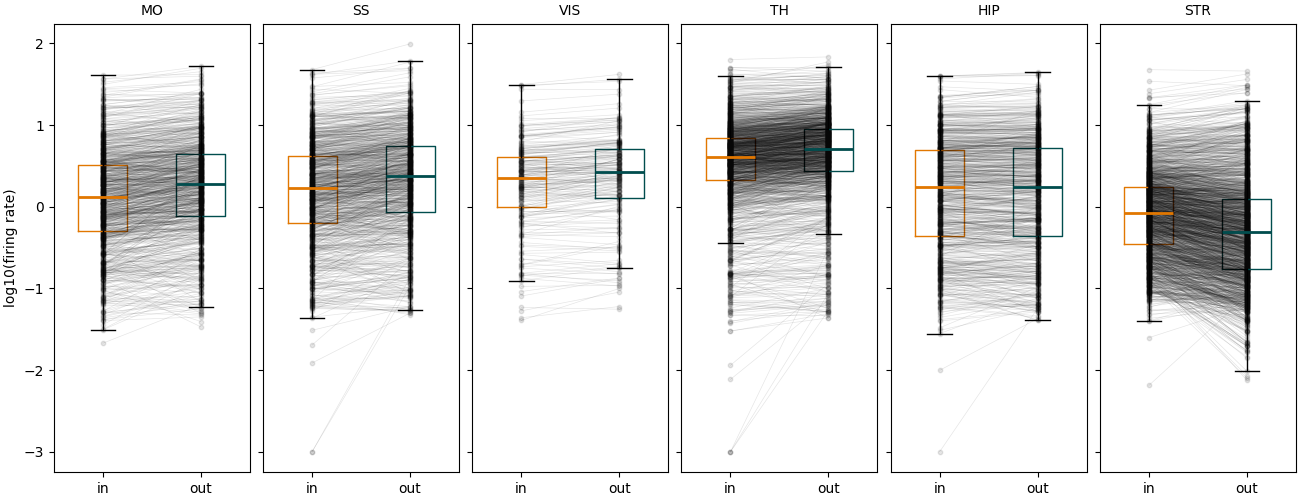

In [34]:
pregions = ['MO', 'SS', 'VIS', 'TH', 'HIP', 'STR']
plot_metrics = {'in': 'log10spFRinSWD', 'out': 'log10spFRoutSWD'}
fig, axs = plt.subplots(1, len(pregions), figsize=(13,5), constrained_layout=True, sharex=True, sharey=True)

for ip, pregi in enumerate(pregions):
    pregdf = SLC_df[SLC_df['parent_region'] == pregi]

    iovals = []
    for ii, (pio, meti) in enumerate(plot_metrics.items()):
        # xs = np.random.normal(ii, 0.1, len(pregdf))
        xs = np.zeros((len(pregdf))) + ii
        axs[ip].boxplot(
            pregdf[meti].values, positions=[ii], widths=[0.5], showfliers=False,
            medianprops={'color': iocolor[pio], 'linewidth': 2}, boxprops={'color': iocolor[pio]}
        )
        axs[ip].scatter(xs, pregdf[meti].values, c='k', marker='o', s=10, alpha=0.1)
        iovals.append(pregdf[meti].values)
    axs[ip].set_title(pregi)
    axs[ip].plot([0,1], np.stack(iovals), color='k', linewidth=0.5, alpha=0.1);
axs[0].set_xticks([0,1])
axs[0].set_xticklabels(['in', 'out'])
axs[0].set_ylabel('log10(firing rate)')

## Save ##
figname = 'multisub_SLC_FR_inout_allregions_{}.png'.format(date.today().strftime('%b%d%Y'))
fig.savefig(os.path.join(plotdir, figname), transparent=False, dpi=150)

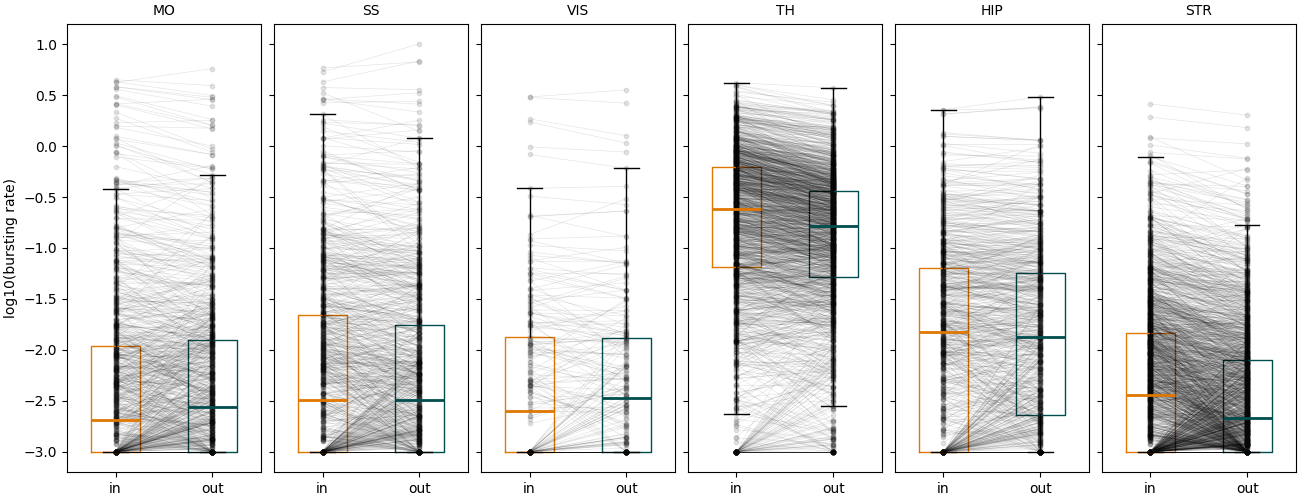

In [36]:
pregions = ['MO', 'SS', 'VIS', 'TH', 'HIP', 'STR']
plot_metrics = {'in': 'log10spBRinSWD', 'out': 'log10spBRoutSWD'}
fig, axs = plt.subplots(1, len(pregions), figsize=(13,5), constrained_layout=True, sharex=True, sharey=True)

for ip, pregi in enumerate(pregions):
    pregdf = SLC_df[SLC_df['parent_region'] == pregi]
    iovals = []
    for ii, (pio, meti) in enumerate(plot_metrics.items()):
        # xs = np.random.normal(ii, 0.1, len(pregdf))
        xs = np.zeros((len(pregdf))) + ii
        axs[ip].boxplot(
            pregdf[meti].values, positions=[ii], widths=[0.5], showfliers=False,
            medianprops={'color': iocolor[pio], 'linewidth': 2}, boxprops={'color': iocolor[pio]}
        )
        axs[ip].scatter(xs, pregdf[meti].values, c='k', marker='o', s=10, alpha=0.1)
        iovals.append(pregdf[meti].values)
    axs[ip].set_title(pregi)
    axs[ip].plot([0,1], np.stack(iovals), color='k', linewidth=0.5, alpha=0.1);
axs[0].set_xticks([0,1])
axs[0].set_xticklabels(['in', 'out'])
axs[0].set_ylabel('log10(bursting rate)')

## Save ##
figname = 'multisub_SLC_BR_inout_allregions_{}.png'.format(date.today().strftime('%b%d%Y'))
fig.savefig(os.path.join(plotdir, figname), transparent=False, dpi=150)

# Thalamic clustering

### For hippocampus

In [95]:
pregions = ['HIP']
pselect = []
for pregi in pregions:
    pselect.append(all_select_units[all_select_units['parent_region'] == pregi])
parentdf = pd.concat(pselect, ignore_index=True)
print(np.unique(parentdf['parent_region'].values))
print(np.unique(parentdf['region'].values))
print(len(parentdf))

['HIP']
['CA1' 'CA2' 'CA3' 'DG-mo' 'DG-po' 'DG-sg' 'alv' 'bsc' 'ccb' 'ccg' 'ccs'
 'fi' 'fiber tracts' 'fp' 'root']
2901


In [98]:
region = 'CA3'
regidf = all_select_units[all_select_units['region'] == region]
print(np.unique(regidf['parent_region'].values))
print(len(regidf))

['HIP']
922


# Older plots

Text(0.5, 1.0, 'Spontaneous firing rates: STR')

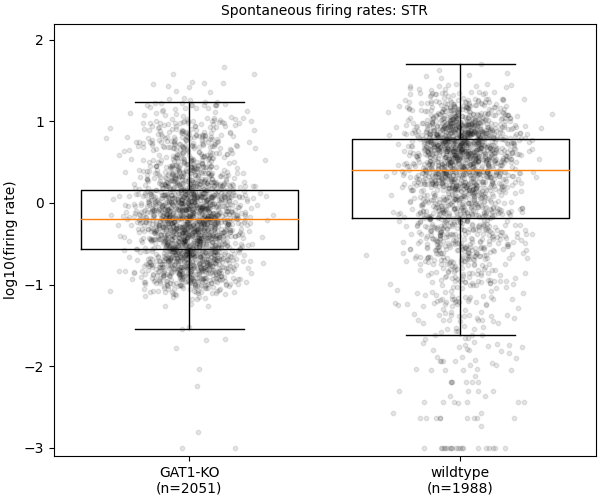

In [16]:
regi = 'STR'
fig, ax = plt.subplots(figsize=(6,5), constrained_layout=True)
xlabels = []
for ii, group in enumerate(['GAT1-KO', 'wildtype']):
    tempdf = all_select_units[(all_select_units['genotype'] == group) & (all_select_units['parent_region'] == regi)]
    yvals = np.log10(tempdf['spont_FR'].values + 1E-3)
    xs = np.random.normal(ii, 0.1, len(yvals))
    ax.boxplot(yvals, positions=[ii], widths=[0.8], showfliers=False)
    ax.scatter(xs, yvals, c='k', marker='o', s=10, alpha=0.1)
    xlabels.append('{}\n(n={:d})'.format(group, len(yvals)))
ax.set_xticks(np.arange(len(xlabels)))
ax.set_xticklabels(xlabels)
ax.set_ylabel('log10(firing rate)')
ax.set_ylim([-3.1, 2.2])

ax.set_title('Spontaneous firing rates: {}'.format(regi))

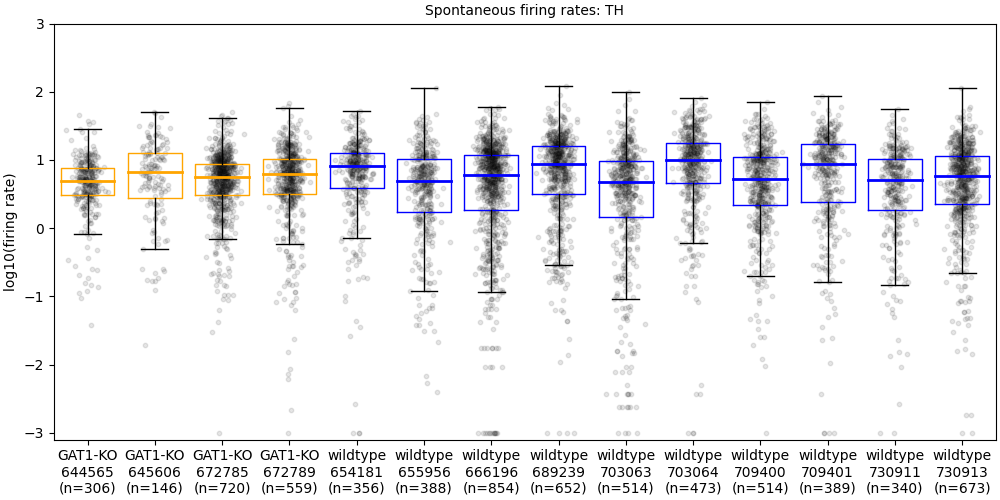

In [19]:
regi = 'TH'
fig, ax = plt.subplots(figsize=(10,5), constrained_layout=True)
xlabels = []
regidf = all_select_units[all_select_units['parent_region'] == regi]
xi = 0
for ii, group in enumerate(['GAT1-KO', 'wildtype']):
    groupdf = regidf[regidf['genotype'] == group]
    if group == 'GAT1-KO':
        gcol = 'orange'
    else:
        gcol = 'blue'
    subjects = np.unique(groupdf['mouse'].values)
    for jj, subi in enumerate(subjects):
        subdf = groupdf[groupdf['mouse'] == subi]
        yvals = np.log10(subdf['spont_FR'].values + 1E-3)
        xs = np.random.normal(xi, 0.1, len(yvals))
        ax.boxplot(yvals, positions=[xi], widths=[0.8], showfliers=False, medianprops={'color': gcol, 'linewidth': 2}, boxprops={'color': gcol})
        ax.scatter(xs, yvals, c='k', marker='o', s=10, alpha=0.1)
        xlabels.append('{}\n{}\n(n={:d})'.format(group, subi, len(yvals)))
        xi += 1
ax.set_xticks(np.arange(xi))
ax.set_xticklabels(xlabels)
ax.set_ylabel('log10(firing rate)')
ax.set_ylim([-3.1, 3.0])
ax.set_title('Spontaneous firing rates: {}'.format(regi))

## Save ##
figname = 'multisub_GAT-control_spontFR_{}_{}.png'.format(regi, date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotdir, figname), transparent=False, dpi=150)

Plot individual regions

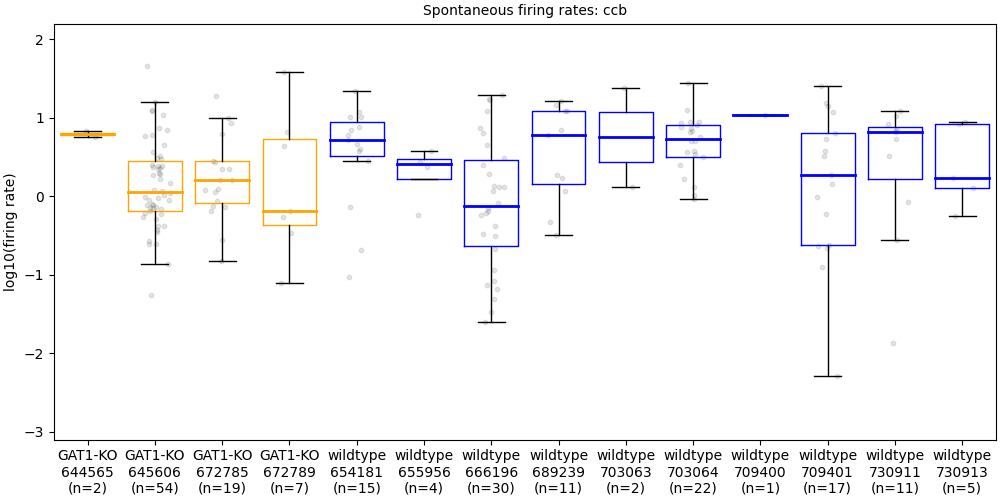

In [69]:
indregi = 'ccb'
fig, ax = plt.subplots(figsize=(10,5), constrained_layout=True)
xlabels = []
regidf = all_select_units[all_select_units['region'] == indregi]
xi = 0
for ii, group in enumerate(['GAT1-KO', 'wildtype']):
    groupdf = regidf[regidf['genotype'] == group]
    if group == 'GAT1-KO':
        gcol = 'orange'
    else:
        gcol = 'blue'
    subjects = np.unique(groupdf['mouse'].values)
    for jj, subi in enumerate(subjects):
        subdf = groupdf[groupdf['mouse'] == subi]
        yvals = np.log10(subdf['spont_FR'].values + 1E-3)
        xs = np.random.normal(xi, 0.1, len(yvals))
        ax.boxplot(yvals, positions=[xi], widths=[0.8], showfliers=False, medianprops={'color': gcol, 'linewidth': 2}, boxprops={'color': gcol})
        ax.scatter(xs, yvals, c='k', marker='o', s=10, alpha=0.1)
        xlabels.append('{}\n{}\n(n={:d})'.format(group, subi, len(yvals)))
        xi += 1
ax.set_xticks(np.arange(xi))
ax.set_xticklabels(xlabels)
ax.set_ylabel('log10(firing rate)')
ax.set_ylim([-3.1, 2.2])
ax.set_title('Spontaneous firing rates: {}'.format(indregi))

## Save ##
figname = 'multisub_GAT-control_spontFR_{}_{}.png'.format(indregi, date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotdir, figname), transparent=False, dpi=150)

#### Bursting

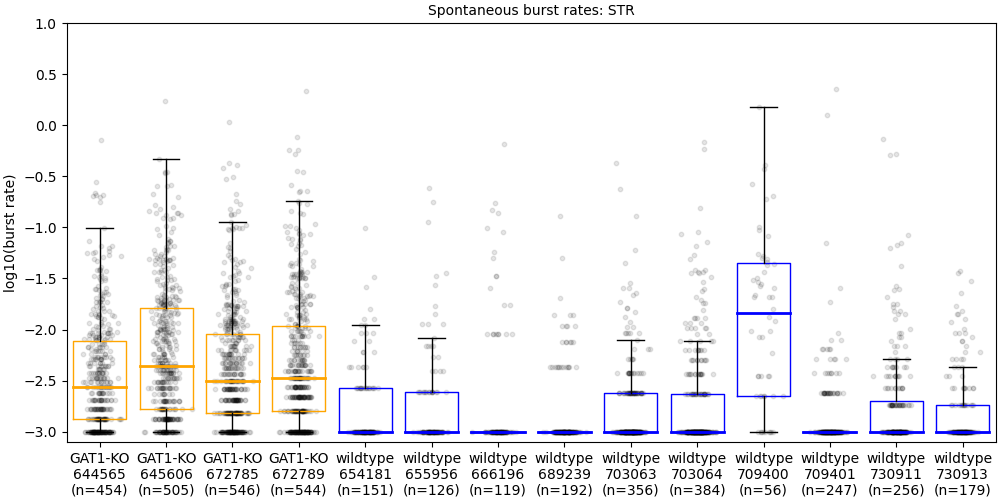

In [17]:
regi = 'STR'
fig, ax = plt.subplots(figsize=(10,5), constrained_layout=True)
xlabels = []
regidf = all_select_units[all_select_units['parent_region'] == regi]
xi = 0
for ii, group in enumerate(['GAT1-KO', 'wildtype']):
    groupdf = regidf[regidf['genotype'] == group]
    if group == 'GAT1-KO':
        gcol = 'orange'
    else:
        gcol = 'blue'
    subjects = np.unique(groupdf['mouse'].values)
    for jj, subi in enumerate(subjects):
        subdf = groupdf[groupdf['mouse'] == subi]
        yvals = np.log10(subdf['spont_BR'].values + 1E-3)
        xs = np.random.normal(xi, 0.1, len(yvals))
        ax.boxplot(yvals, positions=[xi], widths=[0.8], showfliers=False, medianprops={'color': gcol, 'linewidth': 2}, boxprops={'color': gcol})
        ax.scatter(xs, yvals, c='k', marker='o', s=10, alpha=0.1)
        xlabels.append('{}\n{}\n(n={:d})'.format(group, subi, len(yvals)))
        xi += 1
ax.set_xticks(np.arange(xi))
ax.set_xticklabels(xlabels)
ax.set_ylabel('log10(burst rate)')
ax.set_ylim([-3.1, 1.0])
ax.set_title('Spontaneous burst rates: {}'.format(regi))

## Save ##
figname = 'multisub_GAT-control_spontburst_{}_{}.png'.format(regi, date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotdir, figname), transparent=False, dpi=150)

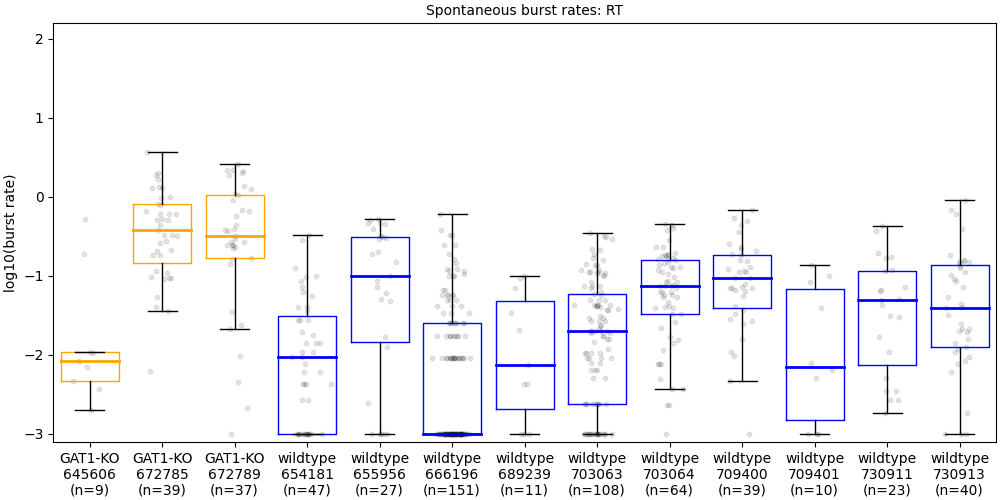

In [16]:
indregi = 'RT'
fig, ax = plt.subplots(figsize=(10,5), constrained_layout=True)
xlabels = []
regidf = all_select_units[all_select_units['region'] == indregi]
xi = 0
for ii, group in enumerate(['GAT1-KO', 'wildtype']):
    groupdf = regidf[regidf['genotype'] == group]
    if group == 'GAT1-KO':
        gcol = 'orange'
    else:
        gcol = 'blue'
    subjects = np.unique(groupdf['mouse'].values)
    for jj, subi in enumerate(subjects):
        subdf = groupdf[groupdf['mouse'] == subi]
        yvals = np.log10(subdf['spont_BR'].values + 1E-3)
        xs = np.random.normal(xi, 0.1, len(yvals))
        ax.boxplot(yvals, positions=[xi], widths=[0.8], showfliers=False, medianprops={'color': gcol, 'linewidth': 2}, boxprops={'color': gcol})
        ax.scatter(xs, yvals, c='k', marker='o', s=10, alpha=0.1)
        xlabels.append('{}\n{}\n(n={:d})'.format(group, subi, len(yvals)))
        xi += 1
ax.set_xticks(np.arange(xi))
ax.set_xticklabels(xlabels)
ax.set_ylabel('log10(burst rate)')
ax.set_ylim([-3.1, 2.2])
ax.set_title('Spontaneous burst rates: {}'.format(indregi))

## Save ##
figname = 'multisub_GAT-control_spontburst_{}_{}.png'.format(indregi, date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotdir, figname), transparent=False, dpi=150)

#### Burst proportion

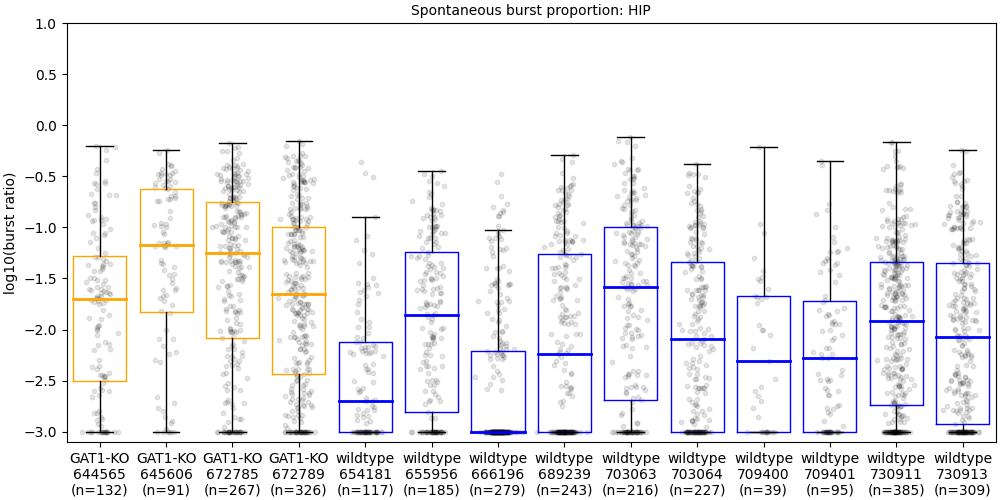

In [28]:
regi = 'HIP'
fig, ax = plt.subplots(figsize=(10,5), constrained_layout=True)
xlabels = []
regidf = all_select_units[all_select_units['parent_region'] == regi]
xi = 0
for ii, group in enumerate(['GAT1-KO', 'wildtype']):
    groupdf = regidf[regidf['genotype'] == group]
    if group == 'GAT1-KO':
        gcol = 'orange'
    else:
        gcol = 'blue'
    subjects = np.unique(groupdf['mouse'].values)
    for jj, subi in enumerate(subjects):
        subdf = groupdf[groupdf['mouse'] == subi]
        yvals = np.log10(subdf['burst_ratio'].values[~np.isnan(subdf['burst_ratio'].values)] + 1E-3)
        xs = np.random.normal(xi, 0.1, len(yvals))
        ax.boxplot(yvals, positions=[xi], widths=[0.8], showfliers=False, medianprops={'color': gcol, 'linewidth': 2}, boxprops={'color': gcol})
        ax.scatter(xs, yvals, c='k', marker='o', s=10, alpha=0.1)
        xlabels.append('{}\n{}\n(n={:d})'.format(group, subi, len(yvals)))
        xi += 1
ax.set_xticks(np.arange(xi))
ax.set_xticklabels(xlabels)
ax.set_ylabel('log10(burst ratio)')
ax.set_ylim([-3.1, 1.0])
ax.set_title('Spontaneous burst proportion: {}'.format(regi))

## Save ##
figname = 'multisub_GAT-control_burstratio_{}_{}.png'.format(regi, date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotdir, figname), transparent=False, dpi=150)

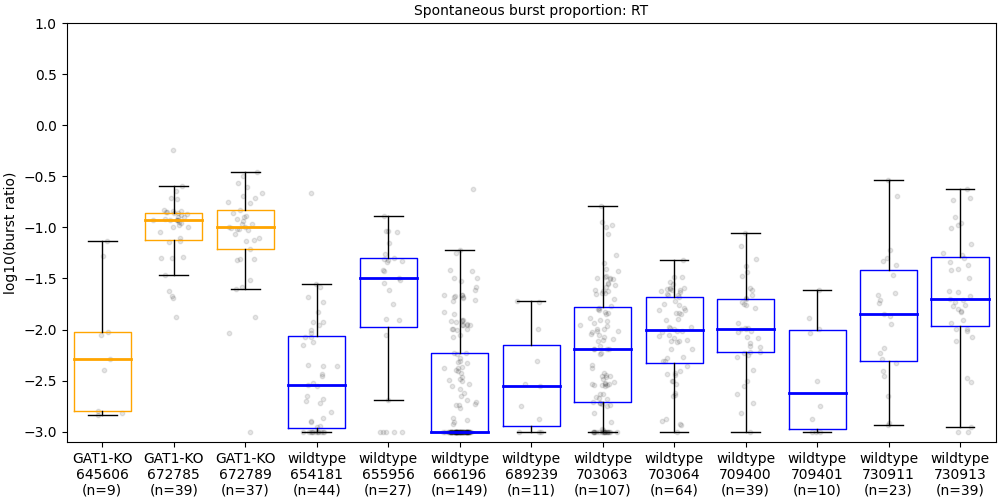

In [30]:
indregi = 'RT'
fig, ax = plt.subplots(figsize=(10,5), constrained_layout=True)
xlabels = []
regidf = all_select_units[all_select_units['region'] == indregi]
xi = 0
for ii, group in enumerate(['GAT1-KO', 'wildtype']):
    groupdf = regidf[regidf['genotype'] == group]
    if group == 'GAT1-KO':
        gcol = 'orange'
    else:
        gcol = 'blue'
    subjects = np.unique(groupdf['mouse'].values)
    for jj, subi in enumerate(subjects):
        subdf = groupdf[groupdf['mouse'] == subi]
        yvals = np.log10(subdf['burst_ratio'].values[~np.isnan(subdf['burst_ratio'].values)] + 1E-3)
        xs = np.random.normal(xi, 0.1, len(yvals))
        ax.boxplot(yvals, positions=[xi], widths=[0.8], showfliers=False, medianprops={'color': gcol, 'linewidth': 2}, boxprops={'color': gcol})
        ax.scatter(xs, yvals, c='k', marker='o', s=10, alpha=0.1)
        xlabels.append('{}\n{}\n(n={:d})'.format(group, subi, len(yvals)))
        xi += 1
ax.set_xticks(np.arange(xi))
ax.set_xticklabels(xlabels)
ax.set_ylabel('log10(burst ratio)')
ax.set_ylim([-3.1, 1.0])
ax.set_title('Spontaneous burst proportion: {}'.format(indregi))

## Save ##
figname = 'multisub_GAT-control_burstratio_{}_{}.png'.format(indregi, date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotdir, figname), transparent=False, dpi=150)